In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import string

# MAIN FIGURE

### Preliminar

#### Helper Function for Loading Curves


In [2]:
def load_curves(dat, key_s="", key_e="", Nfs=1, file_suffix="f_0.0000019073.dat", rescale=False):
    """
    Load curves based on dataset, keys, and rescale options.

    Parameters:
    - dat: Dataset name
    - key_s: Key start string for filtering files
    - key_e: Key end string for filtering files
    - Nfs: Numbers of Degree of Freedoms
    - file_suffix: File suffix for the histogram files
    - rescale: Whether to rescale the data or not

    Returns:
    - Loaded and normalized curves
    """
    try:
        data_to_load = np.array([el for el in os.listdir(f"results/{dat}") if (el.startswith(key_s) and el.endswith(key_e))])
        
        if "RANDOM" in dat:
            histo_final = [np.loadtxt(f"results/{dat}/Histograms_final/Histo_final_{file_suffix}")]   
        else:
            histo_final = [np.loadtxt(f"results/{dat}/{el}/Histograms_final/Histo_final_{file_suffix}") for el in data_to_load]
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

    return [norm_ent(his, Nfs, dat, rescale=rescale, key=key_s+key_e) for his in histo_final]


#### Helper Functions for Normalizing Data

In [3]:
def remove_zero_entries(histo_final):
    """Remove zero entries from the histogram data."""
    return histo_final[histo_final[:, 2] != 0, :]

def rescale_data(histo_final, N, area, P, delta):
    """Rescale the histogram data."""
    baseline = N * np.log(2) - np.log(area)
    baseline1 = 1 / area

    histo_final[:, 0] = histo_final[:, 0] / P
    histo_final[:, 1] = np.exp(histo_final[:, 2] - delta) * baseline1 * P
    histo_final[:, 2] = histo_final[:, 2] - delta + baseline
    return histo_final

def norm_ent(histo_final, N, dat, rescale=True, P=None, key=None):
    """
    Normalize the histogram data.

    Parameters:
    - histo_final: Loaded histogram data
    - N: Number of Degrees of Freedom
    - dat: Dataset name
    - rescale: Whether to rescale or not
    - P: Parameter for rescaling
    - key: Optional key for logging

    Returns:
    - Normalized histogram data
    """
    if P is None:
        P = int(histo_final[-1, 0])

    histo_final = remove_zero_entries(histo_final)
    delta = histo_final[:, 2].min()
    area = np.trapz(np.exp(histo_final[:, 2] - delta), histo_final[:, 0])

    if rescale:
        histo_final = rescale_data(histo_final, N, area, P, delta)
    else:
        histo_final[:, 1] = np.exp(histo_final[:, 2] - delta)

    return histo_final

#### Loading Multiple Curves

In [4]:
def load_multiple_curves(datasets, keys, N_values, file_suffix="f_0.0000019073.dat", rescale=True):
    """
    Load multiple curves from different datasets.

    Parameters:
    - datasets: List of dataset names
    - keys: List of tuples with (key_s, key_e) for each dataset
    - N_values: List of Degrees of Freedom
    - file_suffix: Suffix for the histogram files
    - rescale: Whether to rescale or not

    Returns:
    - Array of loaded curves
    """
    curves = []
    for dat, key, N in zip(datasets, keys, N_values):
        curves.append(load_curves(dat, key[0], key[1], N, file_suffix=file_suffix, rescale=rescale)[0])
    return np.array(curves)


## FIG 1
### Comparative analysis of the density of states (DoS) in classification tasks

#### Loading data

In [5]:
Nrand = [251, 501, 1001]
PMNIST = [78, 784]
Nh_mul = [20, 100]
Nh_bin = [3, 15, 25, 51, 101, 151]

curves_rand = load_multiple_curves([f"RANDOM{N}" for N in Nrand], [["", ""]]*len(Nrand), Nrand)
curves_MNIST = load_multiple_curves(["MNIST", "MNIST"], [["01_a01u_P1", "_39"], ["01_a1u_P1", "_392"]], [784, 784])
curves_MNIST100 = load_multiple_curves(["MNIST100/UNBALANCING/01"] + [f"MNIST100_1L/" for Nh in Nh_bin], 
                                       [["P140_P1_70", ""]] + [[f"{Nh}h_P140_P1", "70"] for Nh in Nh_bin], 
                                       [100] + [100 * Nh + Nh for Nh in Nh_bin])
curves_MNIST100_mul = load_multiple_curves(["MNIST100/MULTIOUT/"] * len(Nh_mul), 
                                           [[f"P200_L{Nh}", ""] for Nh in Nh_mul], 
                                           [100 * Nh + Nh * 10 for Nh in Nh_mul])



#### Plotting Curves

In [6]:
def plot_curve(ax, curve, x_label, y_label, color, ls='-' ,label="", letter="a"):
    """
    Plot a curve on the given axis.

    Parameters:
    - ax: Matplotlib axis to plot on
    - curve: Data to plot
    - x_label: Label for the x-axis
    - y_label: Label for the y-axis
    - title: Plot title
    - color: Color of the plot line
    - label: Legend label
    """
    ax.plot(curve[:, 0], curve[:, 1], lw=4, ls=ls, c=color, label=label)
    ax.set_xlabel(x_label, fontsize=25)
    ax.set_ylabel(y_label, fontsize=25)
    ax.legend(fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.text(-0.15, 1.1, letter ,transform=ax.transAxes, size=30, weight='heavy')

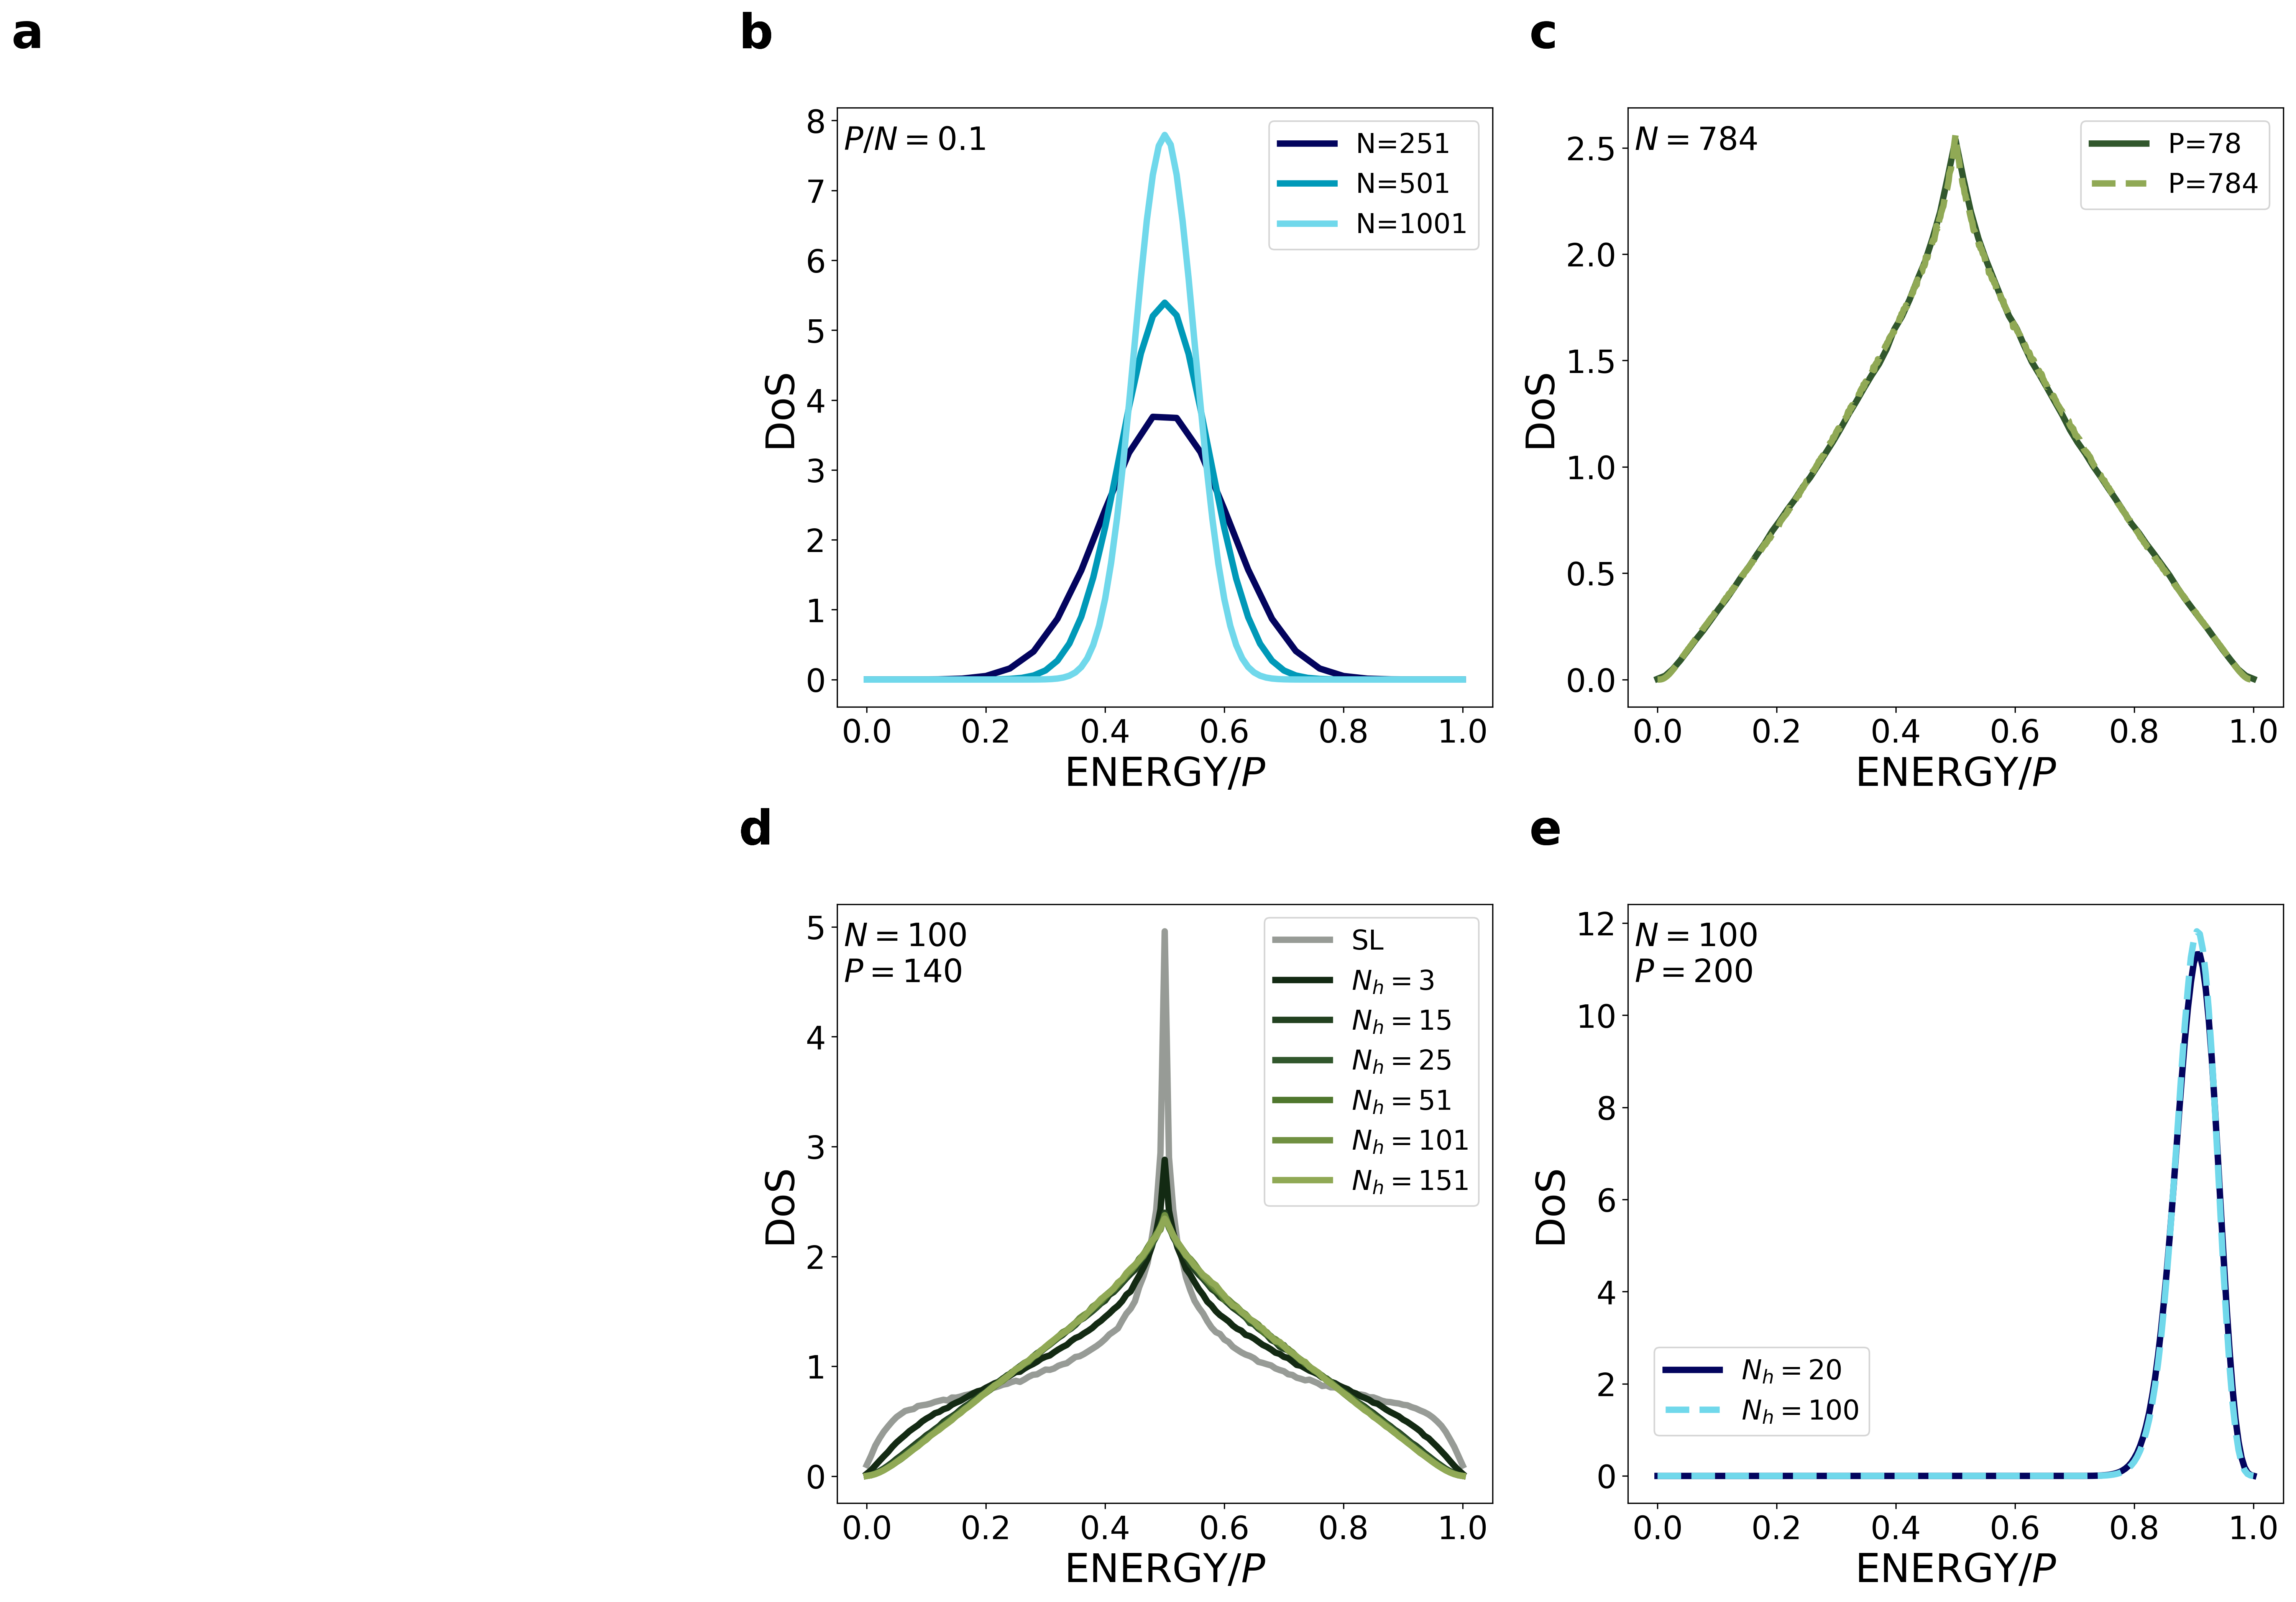

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(20, 14), gridspec_kw={'width_ratios': [0.9, 1, 1]}, dpi=300)

col1 = ["#03045e", "#0099b8", "#70d8eb", "#a4e7f4"]
col2 = ["#31572c", "#90a955"]
col3 = ['#979B96', "#132a13", "#224120", "#31572c", "#4f772d", "#709041", "#90a955"]
col4 = ["#03045e", "#70d8eb", "#0099b8", "#70d8eb", "#a4e7f4"]

leg3 = ["SL"] + [rf"$N_h={n}$" for n in Nh_bin]
ls = ['-', '--']
lw = 4

# Plot RANDOM Curves
for i, curve in enumerate(curves_rand):
    plot_curve(ax[0, 1], curve, r"ENERGY/$P$", r"DoS", col1[i], label=f"N={Nrand[i]}", letter="b")
ax[0, 1].text(0.01, 0.93, r"$P/N = 0.1 $", fontsize=20, transform=ax[0, 1].transAxes)

# Plot MNIST SL Curves
for i, curve in enumerate(curves_MNIST):
    plot_curve(ax[0, 2], curve, r"ENERGY/$P$", r"DoS", col2[i], ls=ls[i], label=f"P={PMNIST[i]}",letter="c")
ax[0, 2].text(0.01, 0.93, r"$N = 784 $", fontsize=20, transform=ax[0, 2].transAxes)

# Plot MNIST100 ML-BINARY Curves
for i, curve in enumerate(curves_MNIST100):
    plot_curve(ax[1, 1], curve, r"ENERGY/$P$", r"DoS", col3[i], label=leg3[i], letter="d")
ax[1, 1].text(0.01, 0.93, r"$N = 100 $", fontsize=20, transform=ax[1, 1].transAxes)
ax[1, 1].text(0.01, 0.87, r"$P = 140 $", fontsize=20, transform=ax[1, 1].transAxes)

# Plot MNIST100 ML-MULTI Curves
for i, curve in enumerate(curves_MNIST100_mul):
    plot_curve(ax[1, 2], curve, r"ENERGY/$P$", r"DoS", col4[i],ls=ls[i], label=f"$N_h={Nh_mul[i]}$",letter="e")
ax[1, 2].text(0.01, 0.93, r"$N = 100 $", fontsize=20, transform=ax[1, 2].transAxes)
ax[1, 2].text(0.01, 0.87, r"$P = 200 $", fontsize=20, transform=ax[1, 2].transAxes)
# Modify the legend location
ax[1, 2].legend(fontsize=17,  bbox_to_anchor=[0.02, 0.09],loc='lower left')

# Hide the empty subplot
ax[0, 0].axis('off')
ax[1, 0].axis('off')
ax[0,0].text(-0.17, 1.1, string.ascii_lowercase[0], transform=ax[0,0].transAxes, size=30, weight='heavy')


plt.tight_layout()
plt.show()

##### Comparative analysis of the density of states (DoS) in classification tasks. 
This analysis covers random or structured data across different network architectures and input dimensions.

**(a)** Blank space to insert schematic representations of the network architectures.

**(b)** Density of states for binary classification of random data by a single-layer perceptron.

**(c)** Density of states for binary classification of the first two classes of the MNIST dataset with $N = 784$ input dimensions, illustrating results for different learning complexities $\left( \frac{P}{N} = 1.0 \text{ and } \frac{P}{N} = 0.1 \right)$.

**(d)** Density of states for binary classification of the first two classes of the MNIST dataset with $N = 100$ input dimensions, with a fixed data size of $P = 140$ and varying network architectures, including a single-layer (SL) perceptron and two-layer perceptrons with different numbers of hidden layer neurons ($N_h$).

**(e)** Density of states for multi-class classification of the MNIST dataset with $N = 100$ input dimensions, showing results for varying numbers of hidden neurons ($N_h$) in the two-layer perceptron.

## Fig 2
### Density of states at a fixed learning complexity of $P/N = 78/784$ resulting in MNIST binary classification for different class imbalances

#### Loading data

In [8]:
datasets = ["MNIST"]
keys = "01_a01u_P1"
N_values = [784]
P1 = [3, 21, 39, 57, 75]  # Adjusted P1 values
curves = load_multiple_curves(["MNIST"]*len(P1), [[keys, f"_{p1}"] for p1 in  P1], N_values*len(P1))


#### Find the peak location

In [9]:
# For a=0.1
data="MNIST"
P1_c=np.array([3,9,15,21,27, 33,39,45, 51, 57,63,69,75])
datasets_c = ["MNIST"] * len(P1_c)  # Repeating "MNIST" for each P1_c value
keys_c = [("01_a01u_P1", f"_{p1}") for p1 in P1_c]  # List of (key_s, key_e) tuples
N_values_c = [784] * len(P1_c)  # Repeating 784 for each P1_c value

curves_c = load_multiple_curves(datasets_c, keys_c, N_values_c)
peak_loss = [hist[np.argmax(hist[:int(hist.shape[0]/2)+1, 1]), 0] for hist in curves_c]

# For a=1
P1_c_b = np.array([3, 27, 51, 75, 99, 123, 147, 171, 195, 219, 243, 267, 291, 315, 339, 363, 387, 392, 397, 421, 445, 469, 493, 517, 541, 565, 589, 613, 637, 661, 685, 709, 733, 757, 781])
datasets_c_b = ["MNIST"] * len(P1_c_b)  # Repeating "MNIST" for each P1_c_b value
keys_c_b = [("01_a1u_P1", f"_{p1}") for p1 in P1_c_b]  # List of (key_s, key_e) tuples
N_values_c_b = [784] * len(P1_c_b)  # Repeating 784 for each P1_c_b value

curves_c_b = load_multiple_curves(datasets_c_b, keys_c_b, N_values_c_b)
peak_loss_b = [hist[np.argmax(hist[:int(hist.shape[0]/2)+1, 1]), 0] for hist in curves_c_b]


#### Plotting curves

In [10]:
def create_combined_legend(ax, handles1, handles2, ncol1=2, ncol2=1, fontsize=20, loc="upper center", bbox=(0.5, 1.3)):
    """
    Create a combined legend for two sets of handles.
    
    Parameters:
    - ax: Axes object to add the legend to.
    - handles1: First set of legend handles (e.g., Line2D objects).
    - handles2: Second set of legend handles to append.
    - ncol1: Number of columns for the first legend.
    - ncol2: Number of columns for the second legend.
    - fontsize: Font size for the legend labels.
    - loc: Location of the legend on the axes.
    - bbox: Bounding box for positioning the legend.
    """
    kw = dict(framealpha=1)
    if bbox:
        kw["bbox_to_anchor"] = bbox

    # Create the first legend
    leg1 = ax.legend(handles=handles1, loc=loc, ncol=ncol1, fontsize=fontsize, **kw)
    ax.add_artist(leg1)

    # Create the second legend
    leg2 = ax.legend(handles=handles2, loc=loc, ncol=ncol2, fontsize=fontsize)
    leg2.remove()
    
    # Combine the legends
    leg1._legend_box._children.append(leg2._legend_handle_box)
    leg1._legend_box.stale = True
    
    return leg1

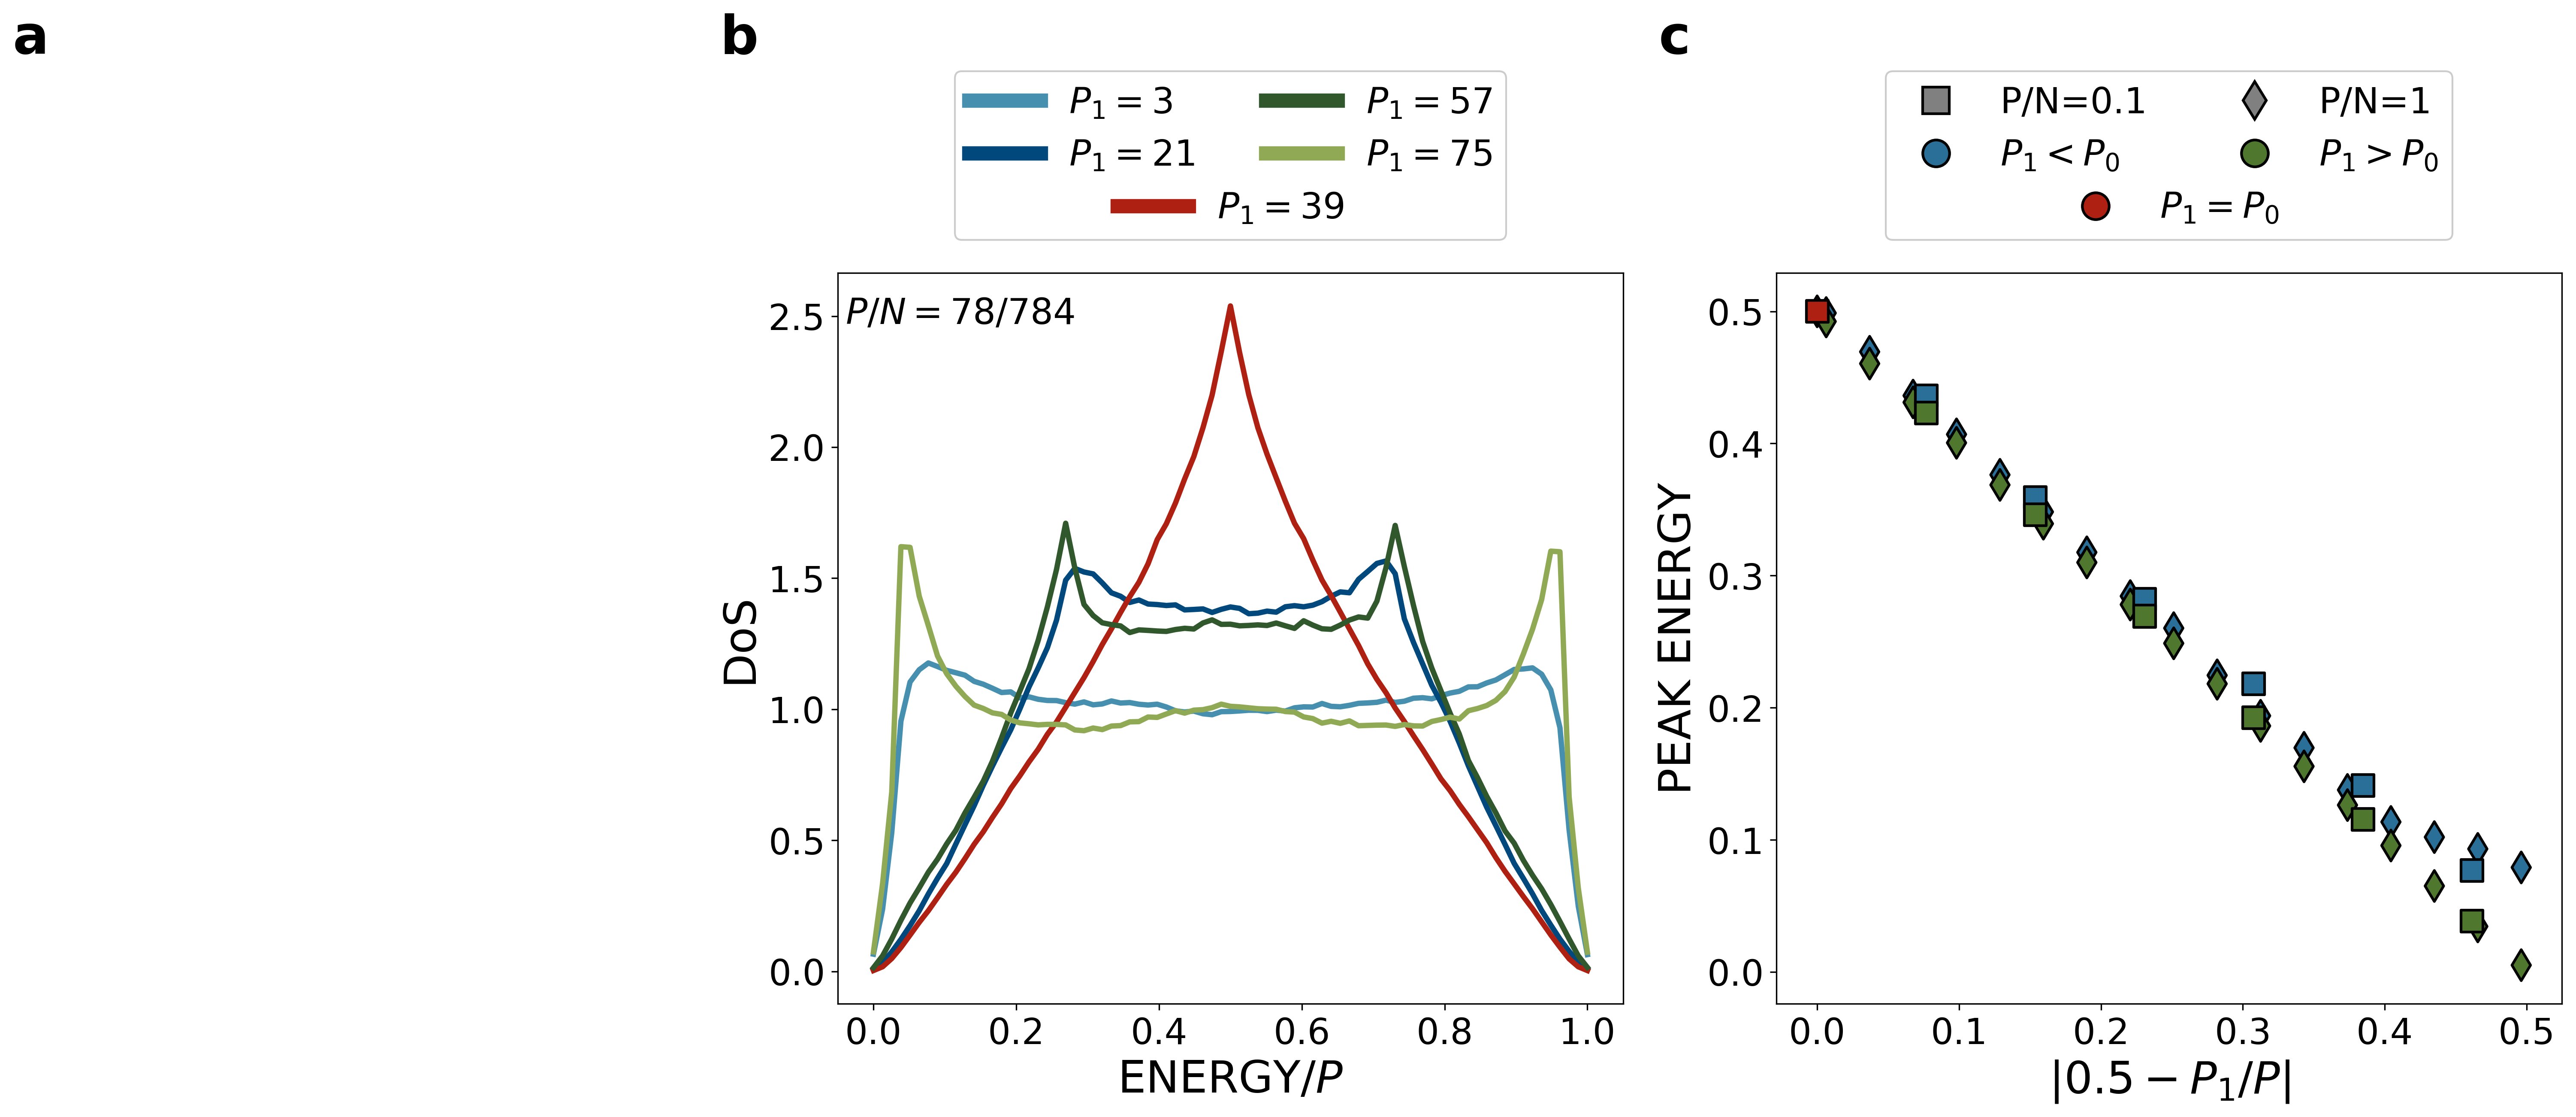

In [11]:
# Define colors and labels
col = ["#468faf", "#01497c", "#ae2012", "#31572c", "#90a955"]  # Adjusted color scheme
col1 = ["#2a6f97"] * 6 + ["#ae2012"] + ["#4f772d"] * 6  # Scatter plot colors for a=0.1
col1_b = ["#2a6f97"] * 17 + ["#ae2012"] + ["#4f772d"] * 17  # Scatter plot colors for a=1
lab = [r"$P_1<P_0$", r"$P_1>P_0$", r"$P_1=P_0$"]

# Create legend handles
legend_handles = [plt.Line2D([0], [0], ls='-', lw=8, color=col[i], label=f"$P_1={P1[i]}$") for i in [0, 1, 3, 4]]
legend_handles_1 = [plt.Line2D([0], [0], ls='-', lw=8, color=col[i], label=f"$P_1={P1[i]}$") for i in [2]]
legend_handles1 = [plt.Line2D([0], [0], ls='', marker="s", ms=15, mec='k', mew=1.5, color="gray", label="P/N=0.1")] + \
                  [plt.Line2D([0], [0], ls='', marker="o", ms=15, mec='k', mew=1.5, color=np.unique(col1)[i], label=lab[i]) for i in [0]] + \
                  [plt.Line2D([0], [0], ls='', marker="d", ms=15, mec='k', mew=1.5, color="gray", label="P/N=1")] + \
                  [plt.Line2D([0], [0], ls='', marker="o", ms=15, mec='k', mew=1.5, color=np.unique(col1)[i], label=lab[i]) for i in [1]]
legend_handles2 = [plt.Line2D([0], [0], ls='', marker="o", ms=15, mec='k', mew=1.5, color=np.unique(col1)[i], label=lab[i]) for i in [2]]

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 9.2), gridspec_kw={'width_ratios': [0.75, 1, 1]}, dpi=300)
ax[0].axis("off")

# Plot the curves
for i in range(len(P1)):
    ax[1].plot(curves[i][:, 0], curves[i][:, 1], '-', c=col[i], lw=3)

# Scatter plot
ax[2].scatter(np.abs(0.5 - P1_c_b / 784), peak_loss_b, marker='d', s=150, edgecolor='k', c=col1_b, lw=1.5)
ax[2].scatter(np.abs(0.5 - P1_c / 78), peak_loss, marker='s', s=150, edgecolor='k', c=col1, lw=1.5)

########################################################  STYLING  #################################################################
# Customize axes
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].text(0.01, 0.93, r"$P/N = 78/784 $", fontsize=20, transform=ax[1].transAxes)
ax[2].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xlabel(r"ENERGY/$P$", fontsize=25)
ax[2].set_xlabel(r"$|0.5 - P_1/P|$", fontsize=25)
ax[1].set_ylabel("DoS", fontsize=25)
ax[2].set_ylabel("PEAK ENERGY", fontsize=25)

# Add legends
create_combined_legend(ax[1], legend_handles, legend_handles_1)
create_combined_legend(ax[2], legend_handles1, legend_handles2)


ax[0].text(-0.14, 1.3, string.ascii_lowercase[0], transform=ax[0].transAxes, size=30, weight='heavy')
ax[1].text(-0.15, 1.3, string.ascii_lowercase[1], transform=ax[1].transAxes, size=30, weight='heavy')
ax[2].text(-0.15, 1.3, string.ascii_lowercase[2], transform=ax[2].transAxes, size=30, weight='heavy')


plt.tight_layout()
plt.show()

##### Density of states at a fixed learning complexity of $P/N = 78/784$ resulting in MNIST binary classification for different class imbalances

**(a)** Blank space to insert schematic representation of class imbalance. 

**(b)** Density of states at a fixed learning complexity of $P/N = 78/784$ for MNIST binary classification with different class imbalances. The legend indicates the number of elements in class 1 ($P_1$). Perfect class balance is achieved when $P_1 = P_0 = P/2 = 39$ (red curve). Larger deviations from this value indicate greater class imbalance. Blue curves represent a predominance of class 0, while green curves represent a predominance of class 1; the lighter the color, the greater the class imbalance.

**(c)** Peak energy values plotted against the absolute difference $|0.5 - P_1/P|$, showing the correlation between peak energy and class imbalance. This correlation does not depend on which class is predominant: blue points indicate class 0 is predominant, and green points indicate class 1 is predominant. Results are shown for two values of learning complexity: $P/N = 0.1$ (squares) and $P/N = 1.0$ (diamonds).

## Fig 3
### Density of states analysis for binary classification of *synthetic* datasets
#### Some preliminar definitions

In [12]:
def dof_curve(rep_l, Δμ, P1=None, Fs=None, N=41, P=60, l_values=None, mode="UNBALANCING", dat=None):
    """
    General function to load peak locations for the given replicates, Δμ values, 
    and either P1 or Fs values, depending on the mode.
    
    Parameters:
    - rep_l: List of replicate indices (cases).
    - Δμ: List of Δμ values.
    - P1: List of P1 values (for "UNBALANCING", 'UNBALANCING_gm' and "UNBALANCING_2ISOgm" modes).
    - Fs: List of Ls values (for "MISLABELLING" mode).
    - N: Number of input neurons (default is 41).
    - P: Numbber of examples P (default is 60).
    - l_values: Optional list of l values. If None, l is not considered.
    - mode: Either "UNBALANCING", "MISLABELLING", 'UNBALANCING_gm' or "UNBALANCING_2ISOgm".
    - dat: Optional base path for the dataset (default depends on mode).

    Returns:
    - p_l: Left peak locations (normalized by P).
    - p_r: Right peak locations (normalized by P).
    """
    p_l, p_r = [], []
    

    # Adjust the base directory based on the mode
    if mode == "UNBALANCING_2ISOgm":
        base_dir = dat if dat else "MNIST100/UNBALANCING_2ISOgm"
    elif mode == "UNBALANCING_gm":
        base_dir = dat if dat else "MNIST100/UNBALANCING_gm"
    elif mode == "UNBALANCING":
        base_dir = "SILICO/UNBALANCING/"
    elif mode == "MISLABELLING":
        base_dir = "SILICO/MISLABELLING/"
    else:
        raise ValueError(f"Invalid mode provided: {mode}. Choose from 'UNBALANCING', 'MISLABELLING', 'UNBALANCING_gm',or 'UNBALANCING_2ISOgm'.")

    if l_values is None:
        # Case for replicates (no l_values)
        template_path_curves = "results/{_dataset_}/{_key_}/Histograms_final/Histo_final_f_0.0000019073.dat"
        
        for rep in rep_l:
            if mode == "UNBALANCING":
                dataset = f"{base_dir}R{rep}/"
                variable_values = P1
                key_template = "N{N}_P{P}_m{m}_P1_{v}"
            elif mode == "MISLABELLING":
                dataset = f"{base_dir}R{rep}/"
                variable_values = Fs
                key_template = "N{N}_P{P}_m{m}_f{v}"
            elif mode == "UNBALANCING_gm":
                dataset = f"{base_dir}/{rep}1/"
                variable_values = P1
                key_template = "P{P}_m{m}_P1_{v}"
            elif mode == "UNBALANCING_2ISOgm":
                dataset = f"{base_dir}/{rep}1/"
                variable_values = P1
                key_template = "P{P}_m{m}_P1_{v}"

            p_l.append([])
            p_r.append([])
            
            for m in np.round(Δμ, 2):
                p_l[-1].append([])
                p_r[-1].append([])
                
                for v in variable_values:
                    try:
                        curve = np.loadtxt(template_path_curves.format(
                            _dataset_=dataset, 
                            _key_=key_template.format(N=N, P=P, m=m, v=v)
                        ))
                        
                        loc_l = np.argmax(curve[:int(P/2+1), 2])
                        loc_r = np.argmax(curve[int(P/2-1):, 2]) + int(P/2-1)

                        p_l[-1][-1].append(curve[loc_l, 0] / P)
                        p_r[-1][-1].append(curve[loc_r, 0] / P)

                    except:
                        print(f"File not found: {template_path_curves.format(_dataset_=dataset, _key_=key_template.format(N=N, P=P, m=m, v=v))}")
                        p_l[-1][-1].append(np.nan)
                        p_r[-1][-1].append(np.nan)
                        
    else:
        # Case for l_values (when using MEAN dataset)
        dataset = "SILICO/MEAN"
        template_path_curves = "results/{_dataset_}/{_key_}/Histograms_final/Histo_final_f_0.0000019073.dat"
        
        for m in np.round(Δμ, 2):
            p_l.append([])
            p_r.append([])
            
            for p1 in P1:
                p_l[-1].append([])
                p_r[-1].append([])
                
                for l in l_values:
                    try:
                        curve = np.loadtxt(template_path_curves.format(
                            _dataset_=dataset, 
                            _key_=f"N{N}_P{P}_m{m}_P1_{p1}_l_{l}"
                        ))
                        loc_l = np.argmax(curve[:int(P/2+1), 2])
                        loc_r = np.argmax(curve[int(P/2-1):, 2]) + int(P/2-1)
                        
                        p_l[-1][-1].append(curve[loc_l, 0] / P)
                        p_r[-1][-1].append(curve[loc_r, 0] / P)
                        
                    except:
                        print(f"File not found: {template_path_curves.format(_dataset_=dataset, _key_=f'N{N}_P{P}_m{m}_P1_{p1}_l_{l}')}")
                        p_l[-1][-1].append(np.NaN)
                        p_r[-1][-1].append(np.NaN)
                        
    return np.array(p_l), np.array(p_r)


In [13]:
# Ensure all curves have the same length (61 points) by padding missing values
def pad_curves(curves, target_len=61):
    """
    Pad the curves to ensure they all have the same length.

    Parameters:
    - curves: The curves to be padded.
    - target_len: Target length for each curve.
    
    Returns:
    - Padded curves with uniform length.
    """
    for i in range(len(curves)):
        for j in range(len(curves[i])):
            if curves[i][j].shape[0] != target_len:
                # Calculate padding size
                padding_size = (target_len - curves[i][j].shape[0]) // 2
                
                # Generate start and end padding
                start_padding = np.c_[np.arange(0, padding_size, 1)/target_len, [0]*padding_size, [np.nan]*padding_size]
                end_padding = np.c_[np.arange(target_len-padding_size, target_len, 1)/target_len, [0]*padding_size, [np.nan]*padding_size]
                
                # Pad the curve with start and end padding
                curves[i][j] = np.r_[start_padding, curves[i][j], end_padding]
    
    return curves

### Inter-class separation
#### Loading data

In [28]:
## Load the curves using existing load_curves() function
key_s = "N41_P60_"
Δμ_values = [0.2, 0.5, 0.7, 1.0, 1.5]
replicates = range(1, 21)

curves = [
    [load_curves(f"SILICO/UNBALANCING/R{r}/", key_s, f"m{m}_P1_30", 41, rescale=True)[0] for m in Δμ_values]
    for r in replicates
]

curves = np.array(curves)

# Ensure all curves have the same length (61 points) by padding missing values
curves = pad_curves(curves)

In [30]:
## Find the peak location for the different replicas
Δμ_full = np.arange(0., 1.52, 0.1)
p_l1, p_r1 = dof_curve([1], Δμ_full, P1=[30], mode="UNBALANCING")

Δμ_rep = np.arange(0.2, 1.51, 0.1)
p_l_a, p_r_a = dof_curve(replicates, Δμ_rep, P1=[30, 1, 10, 20, 39, 49, 59], mode="UNBALANCING")


### Inter-class angle

#### Loading Data

In [31]:
## Load the curves
dat="SILICO/MEAN/"
key_s="N41_P60_m2.0_"
P1_s=[10,20,30,40,50]
curves_an=[load_curves(dat, key_s, f"P1_{p}_l_0.75",  41, rescale=True)[0] for p in P1_s]

In [32]:
Δμ_m = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
P1 = [1, 10, 20, 30, 40, 50, 59]
ls = [0.0, 0.25, 0.5, 0.75, -1.00, -0.75, -0.5, -0.25]

p_l_m, p_r_m = dof_curve([], Δμ_m, P1, l_values=ls)

#### Plotting

In [33]:
def breaking_rules(ax_list_left, ax_list_right, xlim_left, xlim_right, xticks_left=[0.1, 0.3, 0.5, 0.7], xticks_right=[2,3,4,5], d=0.025):
    """
    Breaking rules and axis properties for a list of left and right subplots.

    Parameters:
    - ax_list_left: List of Matplotlib axes objects on the left side where breaking rules should be added.
    - ax_list_right: List of Matplotlib axes objects on the right side where breaking rules should be added.
    - xlim_left: Tuple (xmin, xmax) for the x-axis limits of the left subplots.
    - xlim_right: Tuple (xmin, xmax) for the x-axis limits of the right subplots.
    - d: Distance for the breaking lines. Default is 0.025.
    """
    # Configure left-side subplots
    for ax in ax_list_left:
        ax.spines['right'].set_visible(False)
        ax.set_xlim(*xlim_left)
        # ax.yaxis.set_visible(False)
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
        ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_ylabel("PEAK ENERGY", fontsize=25)
        ax.set_xticks(xticks_left)
    
    # Configure right-side subplots
    for ax in ax_list_right:
        ax.spines['left'].set_visible(False)
        ax.set_xlim(*xlim_right)
        ax.yaxis.set_visible(False)
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)
        ax.plot((-d, +d), (-d, +d), **kwargs)
        
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xticks(xticks_right)


/apps/Python-3.7.2/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


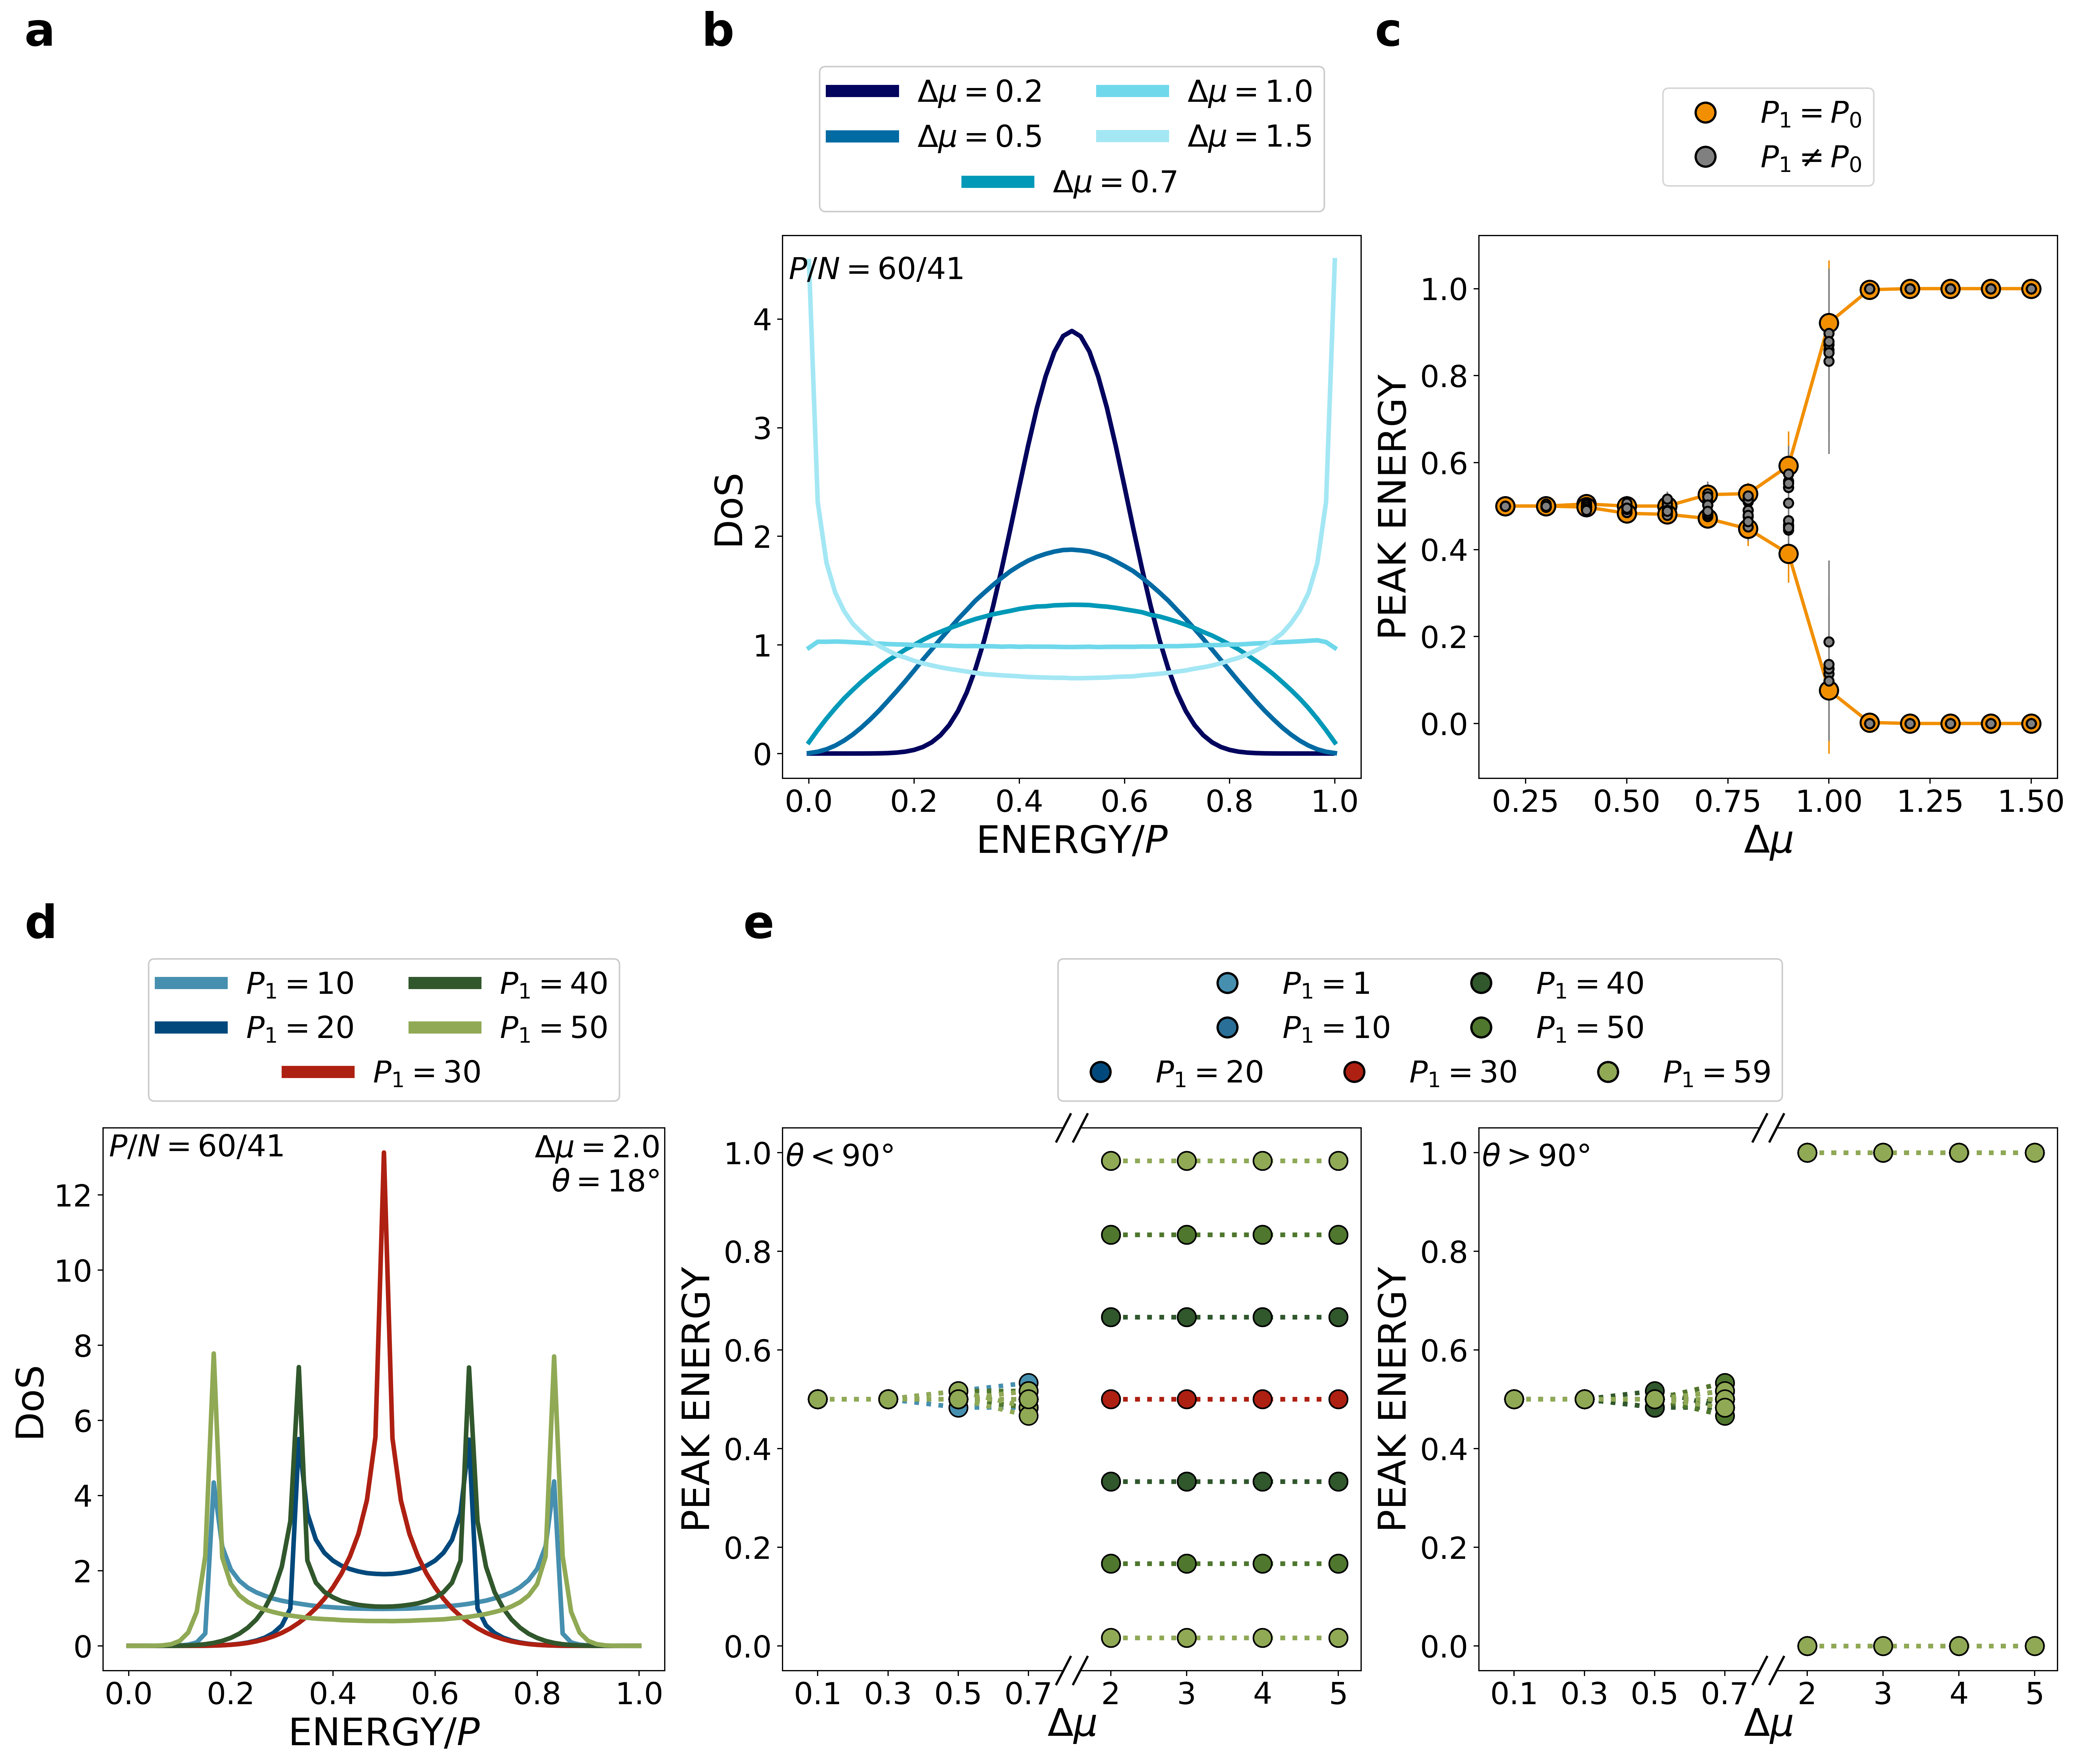

In [34]:
# Define color vectors and labels
main_colors = ["#03045e", "#006aa3", "#0099b8", "#70d8eb", "#a4e7f4"]
aux_colors = ['#F18F01', 'gray']
angle_colors = ["#468faf", "#2a6f97", "#01497c", "#ae2012", "#31572c", "#4f772d", "#90a955"]
dof_colors = [ "#468faf","#01497c","#ae2012","#31572c","#90a955"]
leg_labels = [r"$P_1=P_0$", r"$P_1 \neq P_0$"]
Δμ_1_labels = [fr"$\Delta \mu={Δμ_values[i]}$" for i in range(5)]
P1_dof_labels = [fr"$P_1={P1_s[i]}$" for i in range(5)]
P1_labels = [fr"$P_1={P1[i]}$" for i in range(7)]


# Define legend handles
main_legend = [plt.Line2D([0], [0], ls='-', lw=8, color=main_colors[i], label=Δμ_1_labels[i]) for i in [0, 1, 3, 4]]
aux_legend = [plt.Line2D([0], [0], ls='-', lw=8, color=main_colors[2], label=Δμ_1_labels[2])]
single_legend = [plt.Line2D([0], [0], ls='', marker='o', ms=13, mec='k', mew=1.5, color=aux_colors[i], label=leg_labels[i]) for i in range(2)]

angle_legend_1 = [plt.Line2D([0], [0], ls='-', lw=8, color=dof_colors[i], label=P1_dof_labels[i]) for i in [0, 1, 3, 4]]
angle_legend_2 = [plt.Line2D([0], [0], ls='-', lw=8, color=dof_colors[2], label=P1_dof_labels[2])]

point_legend_1 = [plt.Line2D([0], [0], ls='', marker="o", ms=13, mec='k', mew=1.5, color=angle_colors[i], label=P1_labels[i]) for i in [0, 1, 4, 5]]
point_legend_2 = [plt.Line2D([0], [0], ls='', marker="o", ms=13, mec='k', mew=1.5, color=angle_colors[i], label=P1_labels[i]) for i in [2, 3, 6]]
    


# Create the figure and subplots
fig = plt.figure(figsize=(23,17), dpi=350)  # Create a figure
gs = gridspec.GridSpec(3, 9, width_ratios=[1/3, 0.07 ,1/6, 0.01, 1/6, 0.07 ,1/6, 0.01 ,1/6 ], wspace=0.0, height_ratios=[0.9, 0.3, 0.9] )

# Define subplots
ax_main1 = fig.add_subplot(gs[0, 2:5])
ax_main2 = fig.add_subplot(gs[0, 6:])
ax_dos = fig.add_subplot(gs[2, 0])
ax_zoom1_l = fig.add_subplot(gs[2, 2])
ax_zoom1_r = fig.add_subplot(gs[2, 4], sharey=ax_zoom1_l)
ax_zoom2_l = fig.add_subplot(gs[2, 6], sharey=ax_zoom1_l)
ax_zoom2_r = fig.add_subplot(gs[2, 8], sharey=ax_zoom1_l)


# Invisible axes
invisible_axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[2, 3]), fig.add_subplot(gs[2, 7]), fig.add_subplot(gs[2, 5])]
for ax in invisible_axes:
    ax.axis('off')
    
# Apply breaking rules
breaking_rules([ax_zoom1_l, ax_zoom2_l], [ax_zoom1_r, ax_zoom2_r], (0, 0.8), (1.6, 5.3))
    
for i in range(5):
    ax_main1.plot(curves[:, i].mean(0)[:, 0], curves[:, i].mean(0)[:, 1], ls='-', c=main_colors[i], lw=3)

ax_main2.errorbar(Δμ_rep, p_r_a[0].mean(1), yerr=p_r_a[0].std(1, ddof=1), marker='o', ls='-', ms=12, mew=1.3, lw=2.2, mec='k', c=aux_colors[0], elinewidth=1)
ax_main2.errorbar(Δμ_rep, p_l_a[0].mean(1), yerr=p_l_a[0].std(1, ddof=1), marker='o', ls='-', ms=12, mew=1.3, lw=2.2, mec='k', c=aux_colors[0], elinewidth=1)

for i in range(1,7):
    ax_main2.errorbar(Δμ_rep, p_r_a[i].mean(1), yerr=p_r_a[i].std(1, ddof=1), marker='o', ls='', ms=6, mew=1.3, lw=2.2, mec='k', c=aux_colors[1],elinewidth=1)
    ax_main2.errorbar(Δμ_rep, p_l_a[i].mean(1), yerr=p_l_a[i].std(1, ddof=1), marker='o', ls='', ms=6, mew=1.3, lw=2.2, mec='k', c=aux_colors[1],elinewidth=1)
    


for i in range(5):
    ax_dos.plot(curves_an[i][:,0], curves_an[i][:,1] , '-',c=dof_colors[i], lw=3, )

for i in range(7):
    for j in range(1, 4):
        ax_zoom1_l.plot(Δμ_m[:4], p_r_m[:4, i, j], ":o", c=angle_colors[i], ms=12, mec='k', lw=3)
        ax_zoom1_l.plot(Δμ_m[:4], p_l_m[:4,i,j], ":o", c=angle_colors[i], ms=12, mec='k', lw=3)
        ax_zoom1_r.plot(Δμ_m[-4:], p_r_m[-4:, i, j], ":o", c=angle_colors[i], ms=12, mec='k', lw=3)
        ax_zoom1_r.plot(Δμ_m[-4:], p_l_m[-4:,i,j], ":o", c=angle_colors[i],ms=12, mec='k',lw=3)

for i in range(7):
    for j in range(5, 8):        
        ax_zoom2_l.plot(Δμ_m[:4], p_r_m[:4, i, j], ":o", c=angle_colors[i], ms=12, mec='k', lw=3)
        ax_zoom2_l.plot(Δμ_m[:4], p_l_m[:4,i,j], ":o", c=angle_colors[i], ms=12, mec='k', lw=3)
        ax_zoom2_r.plot(Δμ_m[-4:], p_r_m[-4:, i, j], ":o", c=angle_colors[i], ms=12, mec='k', lw=3)
        ax_zoom2_r.plot(Δμ_m[-4:], p_l_m[-4:,i,j], ":o", c=angle_colors[i],ms=12, mec='k',lw=3)



########################################################  STYLING  #################################################################

invisible_axes[0].text(-0.14, 1.35, string.ascii_lowercase[0], transform=invisible_axes[0].transAxes, size=30, weight='heavy')

## main1
ax_main1.tick_params(axis='both', which='major', labelsize=20)
ax_main1.text(0.01, 0.92, r"$P/N = 60/41$", fontsize=20, transform=ax_main1.transAxes)
ax_main1.set_xlabel(r"ENERGY/$P$", fontsize=25)
ax_main1.set_ylabel("DoS", fontsize=25)
ax_main1.text(-0.14, 1.35, string.ascii_lowercase[1], transform=ax_main1.transAxes, size=30, weight='heavy')
create_combined_legend(ax_main1, main_legend, aux_legend, bbox=(0.5,1.34))

## main 2
ax_main2.tick_params(axis='both', which='major', labelsize=20)
ax_main2.set_xlabel(r"$\Delta \mu$", fontsize=25)
ax_main2.set_ylabel("PEAK ENERGY", fontsize=25)
ax_main2.text(-0.18, 1.35, string.ascii_lowercase[2], transform=ax_main2.transAxes, size=30, weight='heavy')
ax_main2.legend(handles=single_legend, loc='upper center', ncol=1, fontsize=20, bbox_to_anchor=(0.5,1.3))

## ax_dos
ax_dos.tick_params(axis='both', which='major', labelsize=20)
ax_dos.set_ylabel("DoS", fontsize=25)
ax_dos.set_xlabel(r"ENERGY/$P$", fontsize=25)     
ax_dos.text(0.01, 0.99, r"$P/N = 60/41$",fontsize=20, transform=ax_dos.transAxes, va='top')
ax_dos.text(0.99, 0.99, r"$\Delta \mu = 2.0 $"+ "\n"+ r"$\theta = 18°$", ha='right',va='top', fontsize=20, transform=ax_dos.transAxes)
ax_dos.text(-0.14, 1.35, string.ascii_lowercase[3], transform=ax_dos.transAxes, size=30, weight='heavy')
create_combined_legend(ax_dos, angle_legend_1, angle_legend_2, bbox=(0.5,1.34))


## zoom1
ax_zoom1_l.text(0.01, 0.93, r"$\theta < 90°$",fontsize=20, transform=ax_zoom1_l.transAxes)
ax_zoom2_l.text(0.01, 0.93, r"$\theta > 90°$",fontsize=20, transform=ax_zoom2_l.transAxes)
ax_zoom1_l.text(-0.14, 1.35, string.ascii_lowercase[4], transform=ax_zoom1_l.transAxes, size=30, weight='heavy')


for i in range(1,3):
    invisible_axes[i].text(0.5, -0.12, r"$\Delta \mu$", ha='center', fontsize=25)
create_combined_legend(invisible_axes[3], point_legend_1, point_legend_2, ncol2=3, bbox= (0.5,1.34))  
    
plt.tight_layout()

#### Density of states analysis for binary classification of *synthetic* datasets

This study examines the impact of inter-class separation ($\Delta \mu$) and inter-class mean angle ($\theta$). The angle between the two mean vectors ranges from $180^\circ$ to $18^\circ$.

**(a)** Blank space for inserting a pictorial representations of inter-class separation ($\Delta \mu$) and inter-class angle ($\theta$).


**(b)** Density of states at a fixed learning complexity of $P/N = 60/41$ obtained in the binary classification for multiple inter-class separations $\Delta \mu$ for balanced classes. The legend indicates that lighter colors correspond to larger inter-class distances.

**(c)** Peak energy values plotted against the inter-class distance for balanced classes (orange) and imbalanced classes (gray). The plotted values represent the average from 20 independent replicas of the system in the same configuration, with associated statistical deviations.

**(d)** DoS at a fixed learning complexity of $P/N = 60/41$ obtained in the binary classification for large inter-class separations ($\Delta \mu = 2.0$) and small inter-class mean angle ($\theta = 40^\circ$) for different class imbalances. The legend indicates the number of elements in class 1 ($P_1$). Perfect class balance is achieved when $P_1 = P_0 = P/2 = 30$ (red curve). Larger deviations from this value indicate greater class imbalance. Blue curves represent a predominance of class 0, while green curves represent a predominance of class 1; lighter colors indicate greater class imbalance.

**(e)** Peak energy values plotted against the inter-class distance ($\Delta \mu$) for different values of class imbalance as reported in the legend. Red points denote balanced classes. Blue and green points indicate unbalanced classes with a predominance of class 0 and 1, respectively; lighter colors indicate greater imbalance. The two panels differ by the value of the inter-class mean angle, with $\theta > 90^\circ$ on the left and $\theta < 90^\circ$ on the right.


## Fig 4
### Density of states analysis for binary classification of *synthetic* datasets

#### Loading data

In [35]:
key_s=f"N41_P60_m1.3"
curves_mis=[[load_curves(f"SILICO/MISLABELLING/R{r}", key_s, f"_f{f}",  41, rescale=True)[0] for f in [0,5,15,25,30]]  for r in range(1,10)]
curves_mis=np.array(curves_mis)

curves_mis = pad_curves(curves_mis, target_len=61)

In [36]:
Δμ_miss_close = np.arange(0.7, 1.3, 0.1)
Δμ_miss_s = np.arange(0.2, 0.61, 0.1)
Δμ_miss_b = np.arange(1.3, 1.5, 0.1)
Fs = range(0, 31, 5)

p_l_mis_close, p_r_mis_close = dof_curve(range(1, 10), Δμ_miss_close, Fs=Fs, mode="MISLABELLING")
p_l_mis_s, p_r_mis_s = dof_curve(range(1, 2), Δμ_miss_s, Fs=Fs, mode="MISLABELLING")
p_l_mis_b, p_r_mis_b = dof_curve(range(1, 2), Δμ_miss_b, Fs=Fs, mode="MISLABELLING")

In [37]:
p_l_mis_s=np.append(p_l_mis_s[0], p_l_mis_close.mean(0)[0]).reshape(6,7)
p_r_mis_s=np.append(p_r_mis_s[0], p_r_mis_close.mean(0)[0]).reshape(6,7)

#### Plotting 

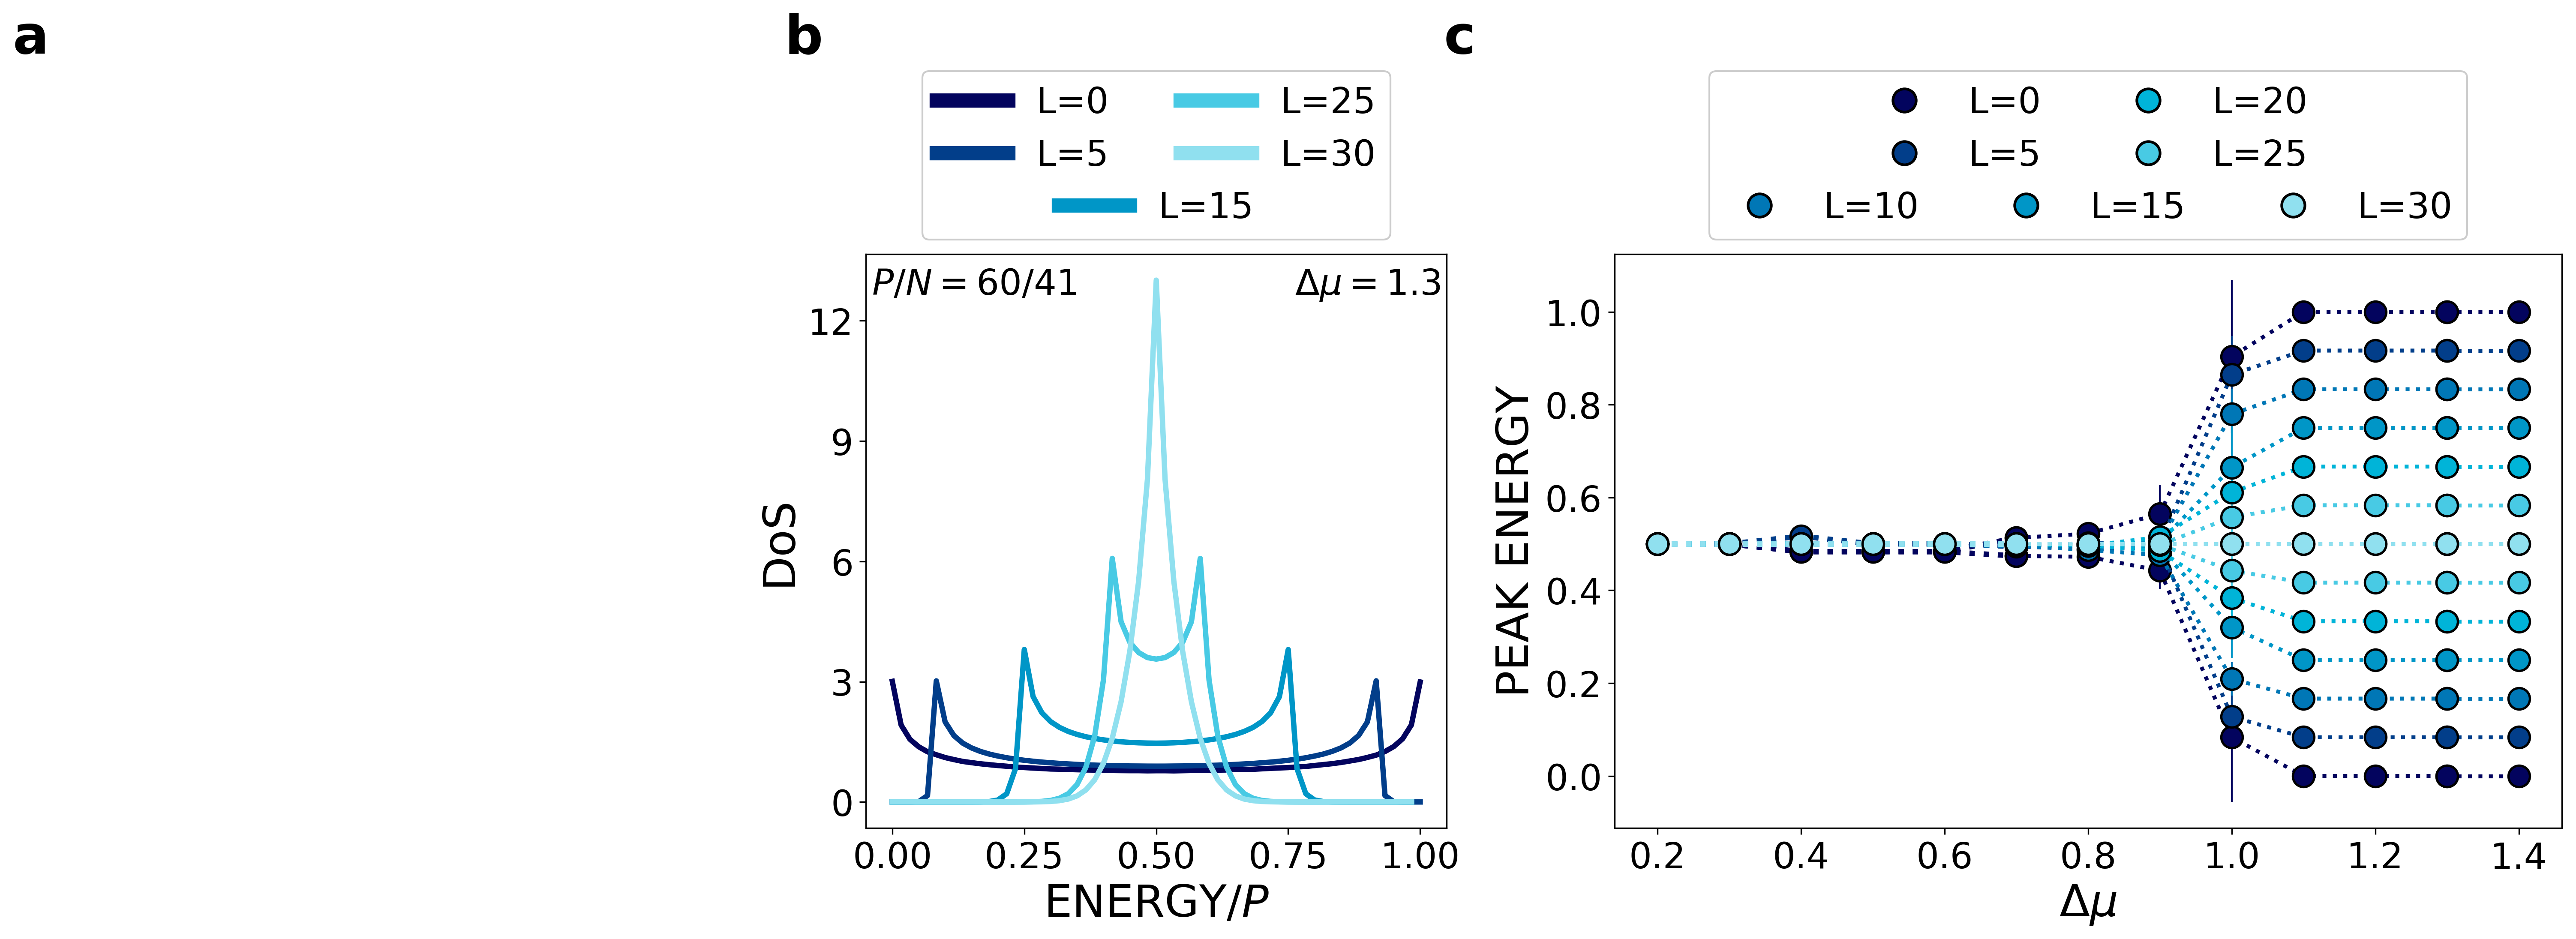

In [38]:
# Define color palettes and labels
col = ["#03045e", "#023e8a", "#0096c7", "#48cae4", "#90e0ef"]
col1 = ["#03045e", "#023e8a", "#0077b6", "#0096c7", "#00b4d8", "#48cae4", "#90e0ef"]
Fs1 = [0, 5, 15, 25, 30]
Fs2 = [0, 5, 10, 15, 20, 25, 30]

# Create legend handles
legend_handles = [plt.Line2D([0], [0], ls='-', lw=8, color=col[i], label=fr"L={Fs1[i]}") for i in [0, 1, 3, 4]]
legend_handles_1 = [plt.Line2D([0], [0], ls='-', lw=8, color=col[2], label=fr"L={Fs1[2]}")]
legend_handles2 = [plt.Line2D([0], [0], ls='', marker="o", ms=13, mec='k', mew=1.5, color=col1[i], label=fr"L={Fs2[i]}") for i in [0, 1, 4, 5]]
legend_handles2_1 = [plt.Line2D([0], [0], ls='', marker="o", ms=13, mec='k', mew=1.5, color=col1[i], label=fr"L={Fs2[i]}") for i in [2, 3, 6]]

# Create figure and subplots
fig = plt.figure(figsize=(20, 8), dpi=300)
gs = gridspec.GridSpec(1, 3, width_ratios=[0.38, 0.38, 0.62])

ax1 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax_ = fig.add_subplot(gs[0, 0])
ax_.axis('off')

# Plot data for ax1
for i in range(5):
    ax1.plot(curves_mis.mean(0)[i][:, 0], curves_mis.mean(0)[i][:, 1], ls='-', c=col[i], lw=3, zorder=-32)

# Plot data for ax3
for i in range(7):
    ax3.plot(np.arange(0.2, 0.71, 0.1), p_l_mis_s[:, i], marker='o', ls=':', ms=12, mew=1.3, lw=3, mec='k', c=col1[i])
    ax3.plot(np.arange(0.2, 0.71, 0.1), p_r_mis_s[:, i], marker='o', ls=':', ms=12, mew=1.3, lw=3, mec='k', c=col1[i])
    ax3.plot(Δμ_miss_b, p_l_mis_b[0][:, i], marker='o', ls=':', ms=12, mew=1.3, lw=2.2, mec='k', c=col1[i])
    ax3.plot(Δμ_miss_b, p_r_mis_b[0][:, i], marker='o', ls=':', ms=12, mew=1.3, lw=2.2, mec='k', c=col1[i])

    ax3.errorbar(Δμ_miss_close, p_l_mis_close.mean(0)[:, i], yerr=p_l_mis_close.std(0, ddof=1)[:, i], ls=':', marker='o', ms=12, mew=1.3, lw=2.2, mec='k', c=col1[i], elinewidth=1)
    ax3.errorbar(Δμ_miss_close, p_r_mis_close.mean(0)[:, i], yerr=p_r_mis_close.std(0, ddof=1)[:, i], ls=':', marker='o', ms=12, mew=1.3, lw=2.2, mec='k', c=col1[i], elinewidth=1)

# Set labels, ticks, and axes formatting
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_yticks([0, 3, 6, 9, 12])
ax1.set_xlabel(r"ENERGY/$P$", fontsize=25)
ax1.set_ylabel("DoS", fontsize=25)
ax1.text(0.01, 0.93, r"$P/N = 60/41 $", fontsize=20, transform=ax1.transAxes)
ax1.text(0.99, 0.93, r"$ \Delta \mu = 1.3 $", fontsize=20, ha="right", transform=ax1.transAxes)

ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.set_xlabel(r"$\Delta \mu$", fontsize=25)
ax3.set_ylabel("PEAK ENERGY", fontsize=25)

# Add combined legends
create_combined_legend(ax1, legend_handles, legend_handles_1, ncol1=2, ncol2=1, bbox=(0.5,1.35))
create_combined_legend(ax3, legend_handles2, legend_handles2_1, ncol1=2, ncol2=3, bbox=(0.5,1.35))


# Add letters for labeling
ax1.text(-0.14, 1.35, string.ascii_lowercase[1], transform=ax1.transAxes, size=30, weight='heavy')
ax3.text(-0.18, 1.35, string.ascii_lowercase[2], transform=ax3.transAxes, size=30, weight='heavy')
ax_.text(-0.18, 1.35, string.ascii_lowercase[0], transform=ax_.transAxes, size=30, weight='heavy')

plt.tight_layout()


#### Density of states analysis for binary classification of *synthetic* datasets

This analysis examines the impact of mislabeled elements at different inter-class separations ($\Delta \mu$).


**(a)** Blank space for inserting a pictorial representation of feature mislabeling for different numbers of mislabeled elements $L$. 

**(b)** Density of states at a fixed learning complexity $P/N = 60/41$ and inter-class separation ($\Delta \mu = 1.3$), obtained in the binary classification for various numbers of mislabeled elements ($L$). The legend indicates that lighter colors correspond to a higher number of mislabeled elements (greater $L$).

**(c)** Peak energy values plotted against the inter-class distance for different numbers of misclassified elements. The plotted values in the range $\Delta \mu \in [0.8, 1.3]$ represent the average from 10 independent replicas of the system in the same configuration, with associated statistical deviations.



# SUP FIGURE

In [39]:
from itertools import product
from scipy.optimize import curve_fit
from scipy.stats import chisquare

### Preliminar definition

In [40]:
# Activation function: binary step (sign function)
def binary_step(x):
    """
    Applies the binary step function.
    Returns 1 for x >= 0, otherwise -1.
    """
    return np.where(x >= 0, 1, -1)

# Activation function for the output layer: argmax for multi-class classification
def output_activation(x):
    """
    Returns the index of the maximum value for each sample.
    Used in multi-class classification.
    """
    return np.argmax(x, axis=1)

# Generate synthetic data using a random MLP model
def generate_synthetic_data(n_samples, layer_sizes, random_seed=None):
    """
    Generates synthetic data for a multi-layer perceptron (MLP) model.

    Parameters:
    - n_samples: int, number of samples
    - layer_sizes: list, defines the size of each layer in the MLP
    - random_seed: int, optional seed for reproducibility

    Returns:
    - X: ndarray, generated input data
    - y: ndarray, labels produced by the MLP
    - weights: list of ndarrays, binary weight matrices
    """
    if random_seed:
        np.random.seed(random_seed)
    
    # Input layer data
    X = np.random.randn(n_samples, layer_sizes[0])

    # Randomly initialize binary weights (+1 or -1)
    weights = [np.random.choice([-1, 1], size=(layer_sizes[i], layer_sizes[i + 1])) 
               for i in range(len(layer_sizes) - 1)]

    # Forward pass through the MLP
    layer_input = X
    for W in weights[:-1]:
        layer_input = binary_step(layer_input @ W)

    # Output layer processing
    if layer_sizes[-1] == 1:
        y = binary_step(layer_input @ weights[-1])  # Binary output
    else:
        y_probs = layer_input @ weights[-1]
        y = output_activation(y_probs)  # Multi-class output
    
    return X, y, weights

# Initialize binary weights
def init_binary_weights(shape, random_seed=None):
    """
    Initializes binary weights randomly (+1 or -1).

    Parameters:
    - shape: tuple, the shape of the weight matrix
    - random_seed: int, optional seed for reproducibility

    Returns:
    - weights: ndarray of binary values (+1 or -1)
    """
    if random_seed:
        np.random.seed(random_seed)
    
    return np.random.choice([-1, 1], size=shape)

# Forward pass through the MLP
def forward_pass_through_mlp(X, weights, output_layer_size):
    """
    Performs a forward pass through the MLP.

    Parameters:
    - X: ndarray, input data
    - weights: list of weight matrices for each layer
    - output_layer_size: int, size of the output layer

    Returns:
    - y_pred: ndarray, predictions from the MLP
    """
    layer_input = X
    for W in weights[:-1]:
        layer_input = binary_step(layer_input @ W)

    if output_layer_size == 1:
        y_pred = binary_step(layer_input @ weights[-1])  # Binary output
    else:
        y_probs = layer_input @ weights[-1]
        y_pred = output_activation(y_probs)  # Multi-class output

    return y_pred

# Compute the number of misclassifications (loss function)
def compute_misclassification_loss(y_true, y_pred):
    """
    Computes the loss as the number of misclassified samples.

    Parameters:
    - y_true: ndarray, true labels
    - y_pred: ndarray, predicted labels

    Returns:
    - loss: int, number of misclassified samples
    """
    return np.sum(y_true != y_pred)

# Evaluate all possible weight combinations to compute losses
def evaluate_all_weights(X, y_true, layer_sizes):
    """
    Evaluates the loss for all possible binary weight combinations.

    Parameters:
    - X: ndarray, input data
    - y_true: ndarray, true labels
    - layer_sizes: list, size of each layer in the MLP

    Returns:
    - losses: list of losses corresponding to each weight combination
    """
    # Determine the shapes of the weight matrices
    weight_shapes = [(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)]

    # Generate all possible weight combinations
    weight_combinations = [list(product([-1, 1], repeat=np.prod(shape))) for shape in weight_shapes]

    # Compute loss for each combination of weights
    losses = []
    for weights_tuple in product(*weight_combinations):
        weights = [np.array(w).reshape(shape) for w, shape in zip(weights_tuple, weight_shapes)]
        y_pred = forward_pass_through_mlp(X, weights, layer_sizes[-1])
        loss = compute_misclassification_loss(y_true, y_pred)
        losses.append(loss)

    return losses


## VALIDATION

In order to reproduce the same results presentet in the paper use random_seed=2

### SINGLE-LAYER
#### Generate the data and compute the exact entropy curve

In [42]:
# Set the random seed for reproducibility
random_seed = 2  
n_samples = 15

# Define layer sizes for a single-layer MLP (input and output layer)
layer_sizes_1L = [15, 1] 

# Generate synthetic data using the new function structure
X_1L, Y_1L, weights_1L = generate_synthetic_data(n_samples, layer_sizes_1L, random_seed)

# Compute the losses for all possible weight combinations
losses_1L = evaluate_all_weights(X_1L, Y_1L, layer_sizes_1L)

# Get unique loss values and their counts
xl_1L, yl_1L = np.unique(losses_1L, return_counts=True)

#### Upload the curve computed by WL-algorithm

In [43]:
curve_1L = load_curves("VALIDATION", "1L_N15_P15", "", 15, rescale = True)
len(curve_1L)

500

In [44]:
## compute the percentage distance
dist_1L=[]
for hist in curve_1L:
    dist_1L.append(np.abs(hist[:,2]-np.log(yl_1L))/np.log(yl_1L))
    
dist_1L=np.array(dist_1L)

##### Plotting

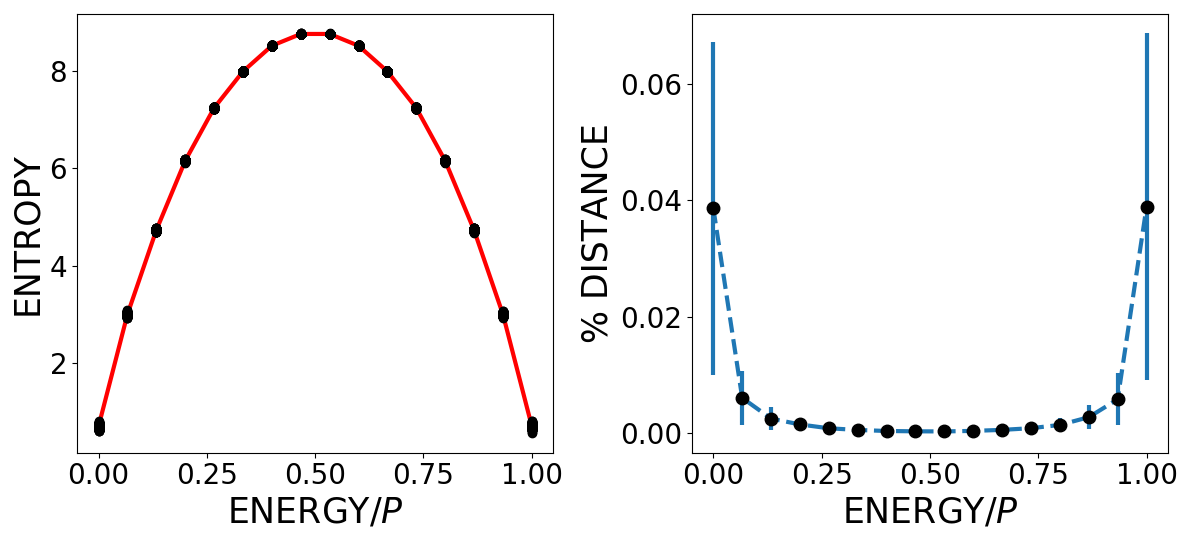

In [45]:
fig, ax= plt.subplots(1,2, figsize=(12,5.5), dpi=100)


ax[0].plot(xl_1L/15,np.log(yl_1L), '.-', c='r', lw=3)

for hist in curve_1L:
    ax[0].plot(hist[:,0], hist[:,2], 'o', c='k')
    
ax[1].errorbar(xl_1L/15, dist_1L.mean(0), yerr=dist_1L.std(0,ddof=1), marker='o', ls='--', mfc='k', mec='k', ms=9, lw=3);    

ax[0].tick_params(axis='both', which='major', labelsize=20)
#ax[0].text(0.01, 0.93, r"$P/N = 15/15 $",fontsize=20, transform=ax[0].transAxes)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel(r"ENERGY/$P$", fontsize=25)     
ax[1].set_xlabel(r"ENERGY/$P$", fontsize=25)    
ax[0].set_ylabel("ENTROPY", fontsize=25)
ax[1].set_ylabel("% DISTANCE", fontsize=25)

plt.tight_layout()

### 2-LAYER BINARY CLASSIFICATION

#### Generate the data and compute the exact entropy curve

In [46]:
# Set the random seed for reproducibility
random_seed = 2  
n_samples = 18

# Define layer sizes for a two-layer MLP (input, hidden, and output layer)
layer_sizes_2L = [5, 3, 1] 

# Generate synthetic data using the new function structure
X_2L, Y_2L, weights_2L = generate_synthetic_data(n_samples, layer_sizes_2L, random_seed)

# Compute the losses for all possible weight combinations
losses_2L = evaluate_all_weights(X_2L, Y_2L, layer_sizes_2L)

# Get unique loss values and their counts
xl_2L, yl_2L = np.unique(losses_2L, return_counts=True)

#### Upload the curve computed by WL-algorithm

In [47]:
curve_2L = load_curves("VALIDATION", "2L_N5_H3_O1_P18", "", 18, rescale = True)
len(curve_2L)

500

In [48]:
## compute the percentage distance
dist_2L=[]
for hist in curve_2L:
    dist_2L.append(np.abs(hist[:,2]-np.log(yl_2L))/np.log(yl_2L))
    
dist_2L=np.array(dist_2L)

##### Plotting

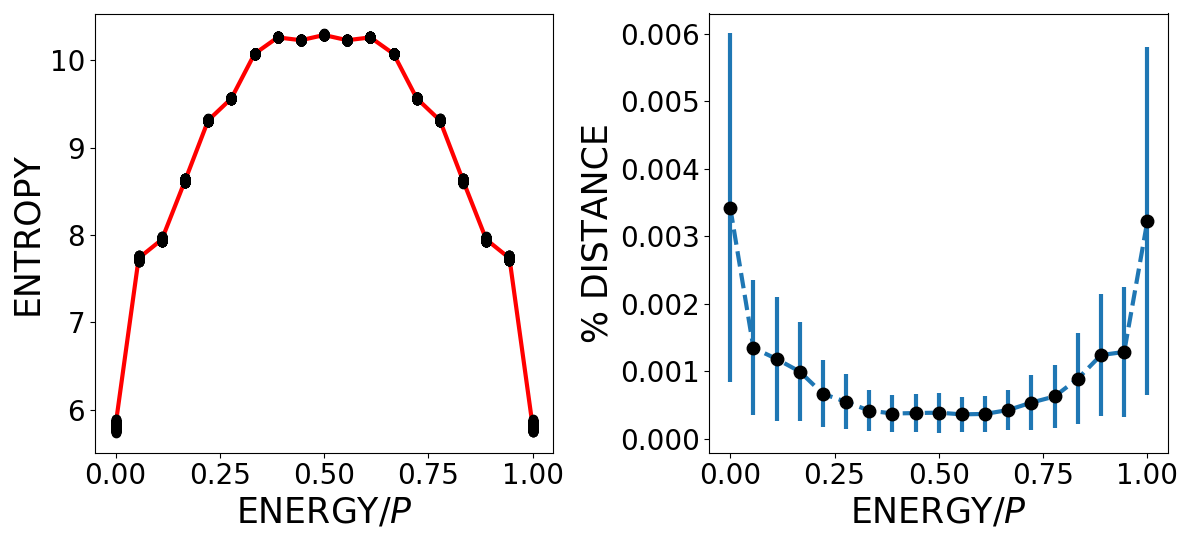

In [49]:
fig, ax= plt.subplots(1,2, figsize=(12,5.5), dpi=100)

ax[0].plot(xl_2L/18,np.log(yl_2L), '-', c='r', lw=3)
for hist in curve_2L:
    ax[0].plot(hist[:,0], hist[:,2], 'o', c='k')
    
ax[1].errorbar(xl_2L/18, dist_2L.mean(0), yerr=dist_2L.std(0,ddof=1), marker='o', ls='--', mfc='k', mec='k', ms=9, lw=3);    

ax[0].tick_params(axis='both', which='major', labelsize=20)
# ax[0].text(0.01, 0.93, r"$P/N = 15/15 $",fontsize=20, transform=ax[0].transAxes)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel(r"ENERGY/$P$", fontsize=25)     
ax[1].set_xlabel(r"ENERGY/$P$", fontsize=25)    
ax[0].set_ylabel("ENTROPY", fontsize=25)
ax[1].set_ylabel("% DISTANCE", fontsize=25)

plt.tight_layout()

### 2-LAYER MULTICLASS CLASSIFICATION
#### Generate the data and compute the exact entropy curve

In [50]:
# Set the random seed for reproducibility
random_seed = 2  
n_samples = 15

# Define layer sizes for a two-layer MLP (input, hidden, and output layer with 3 output neurons)
layer_sizes_2L_O3 = [3, 3, 3] 

# Generate synthetic data using the new function structure
X_2L_O3, Y_2L_O3, weights_2L_O3 = generate_synthetic_data(n_samples, layer_sizes_2L_O3, random_seed)

# Compute the losses for all possible weight combinations
losses_2L_O3 = evaluate_all_weights(X_2L_O3, Y_2L_O3, layer_sizes_2L_O3)

# Get unique loss values and their counts
xl_2L_O3, yl_2L_O3 = np.unique(losses_2L_O3, return_counts=True)

#### Upload the curve computed by WL-algorithm

In [51]:
curve_2L_O3 = load_curves("VALIDATION", "2L_N3_H3_O3_P15", "", 18, rescale = True)
len(curve_2L_O3)

500

In [52]:
# compute the distance
dist_2L_O3=[]
for hist in curve_2L_O3:
    dist_2L_O3.append(np.abs(hist[:,2]-np.log(yl_2L_O3))/np.log(yl_2L_O3))
    
dist_2L_O3=np.array(dist_2L_O3)

#### Plotting

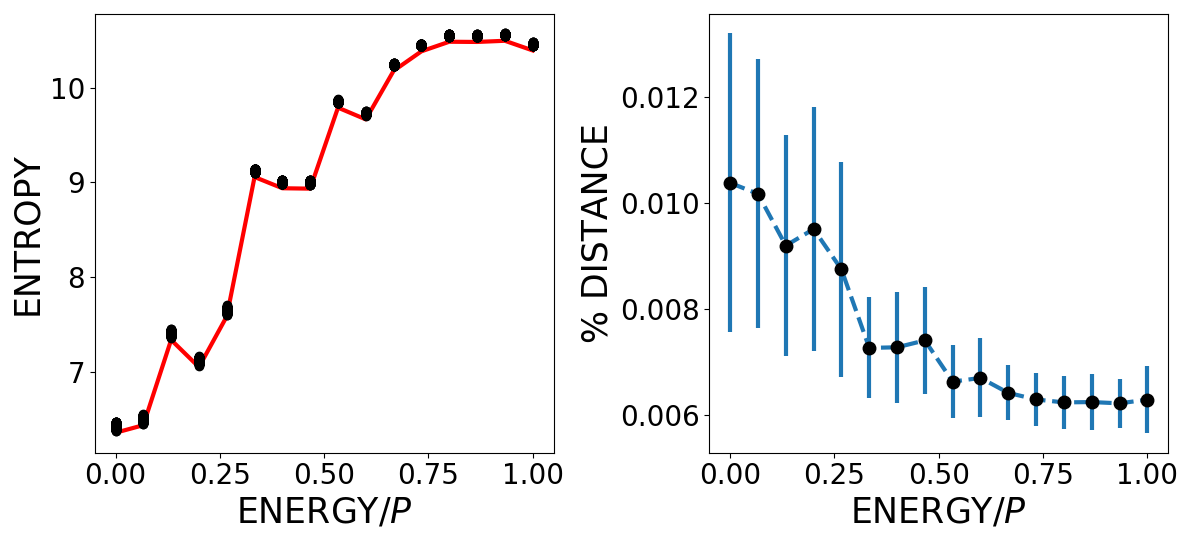

In [53]:
fig, ax= plt.subplots(1,2, figsize=(12,5.5), dpi=100)


ax[0].plot(xl_2L_O3/15,np.log(yl_2L_O3), '-', c='r', lw=3)
for hist in curve_2L_O3:
    ax[0].plot(hist[:,0], hist[:,2], 'o', c='k')

ax[1].errorbar(xl_2L_O3/15, dist_2L_O3.mean(0), yerr=dist_2L_O3.std(0,ddof=1), marker='o', ls='--', mfc='k', mec='k', ms=9, lw=3);    

    
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel(r"ENERGY/$P$", fontsize=25)     
ax[1].set_xlabel(r"ENERGY/$P$", fontsize=25)    
ax[0].set_ylabel("ENTROPY", fontsize=25)
ax[1].set_ylabel("% DISTANCE", fontsize=25)

# fig.suptitle("P=15 - Net: 3 x 3 x 3",fontsize=20)

plt.tight_layout()

#### Complete figure

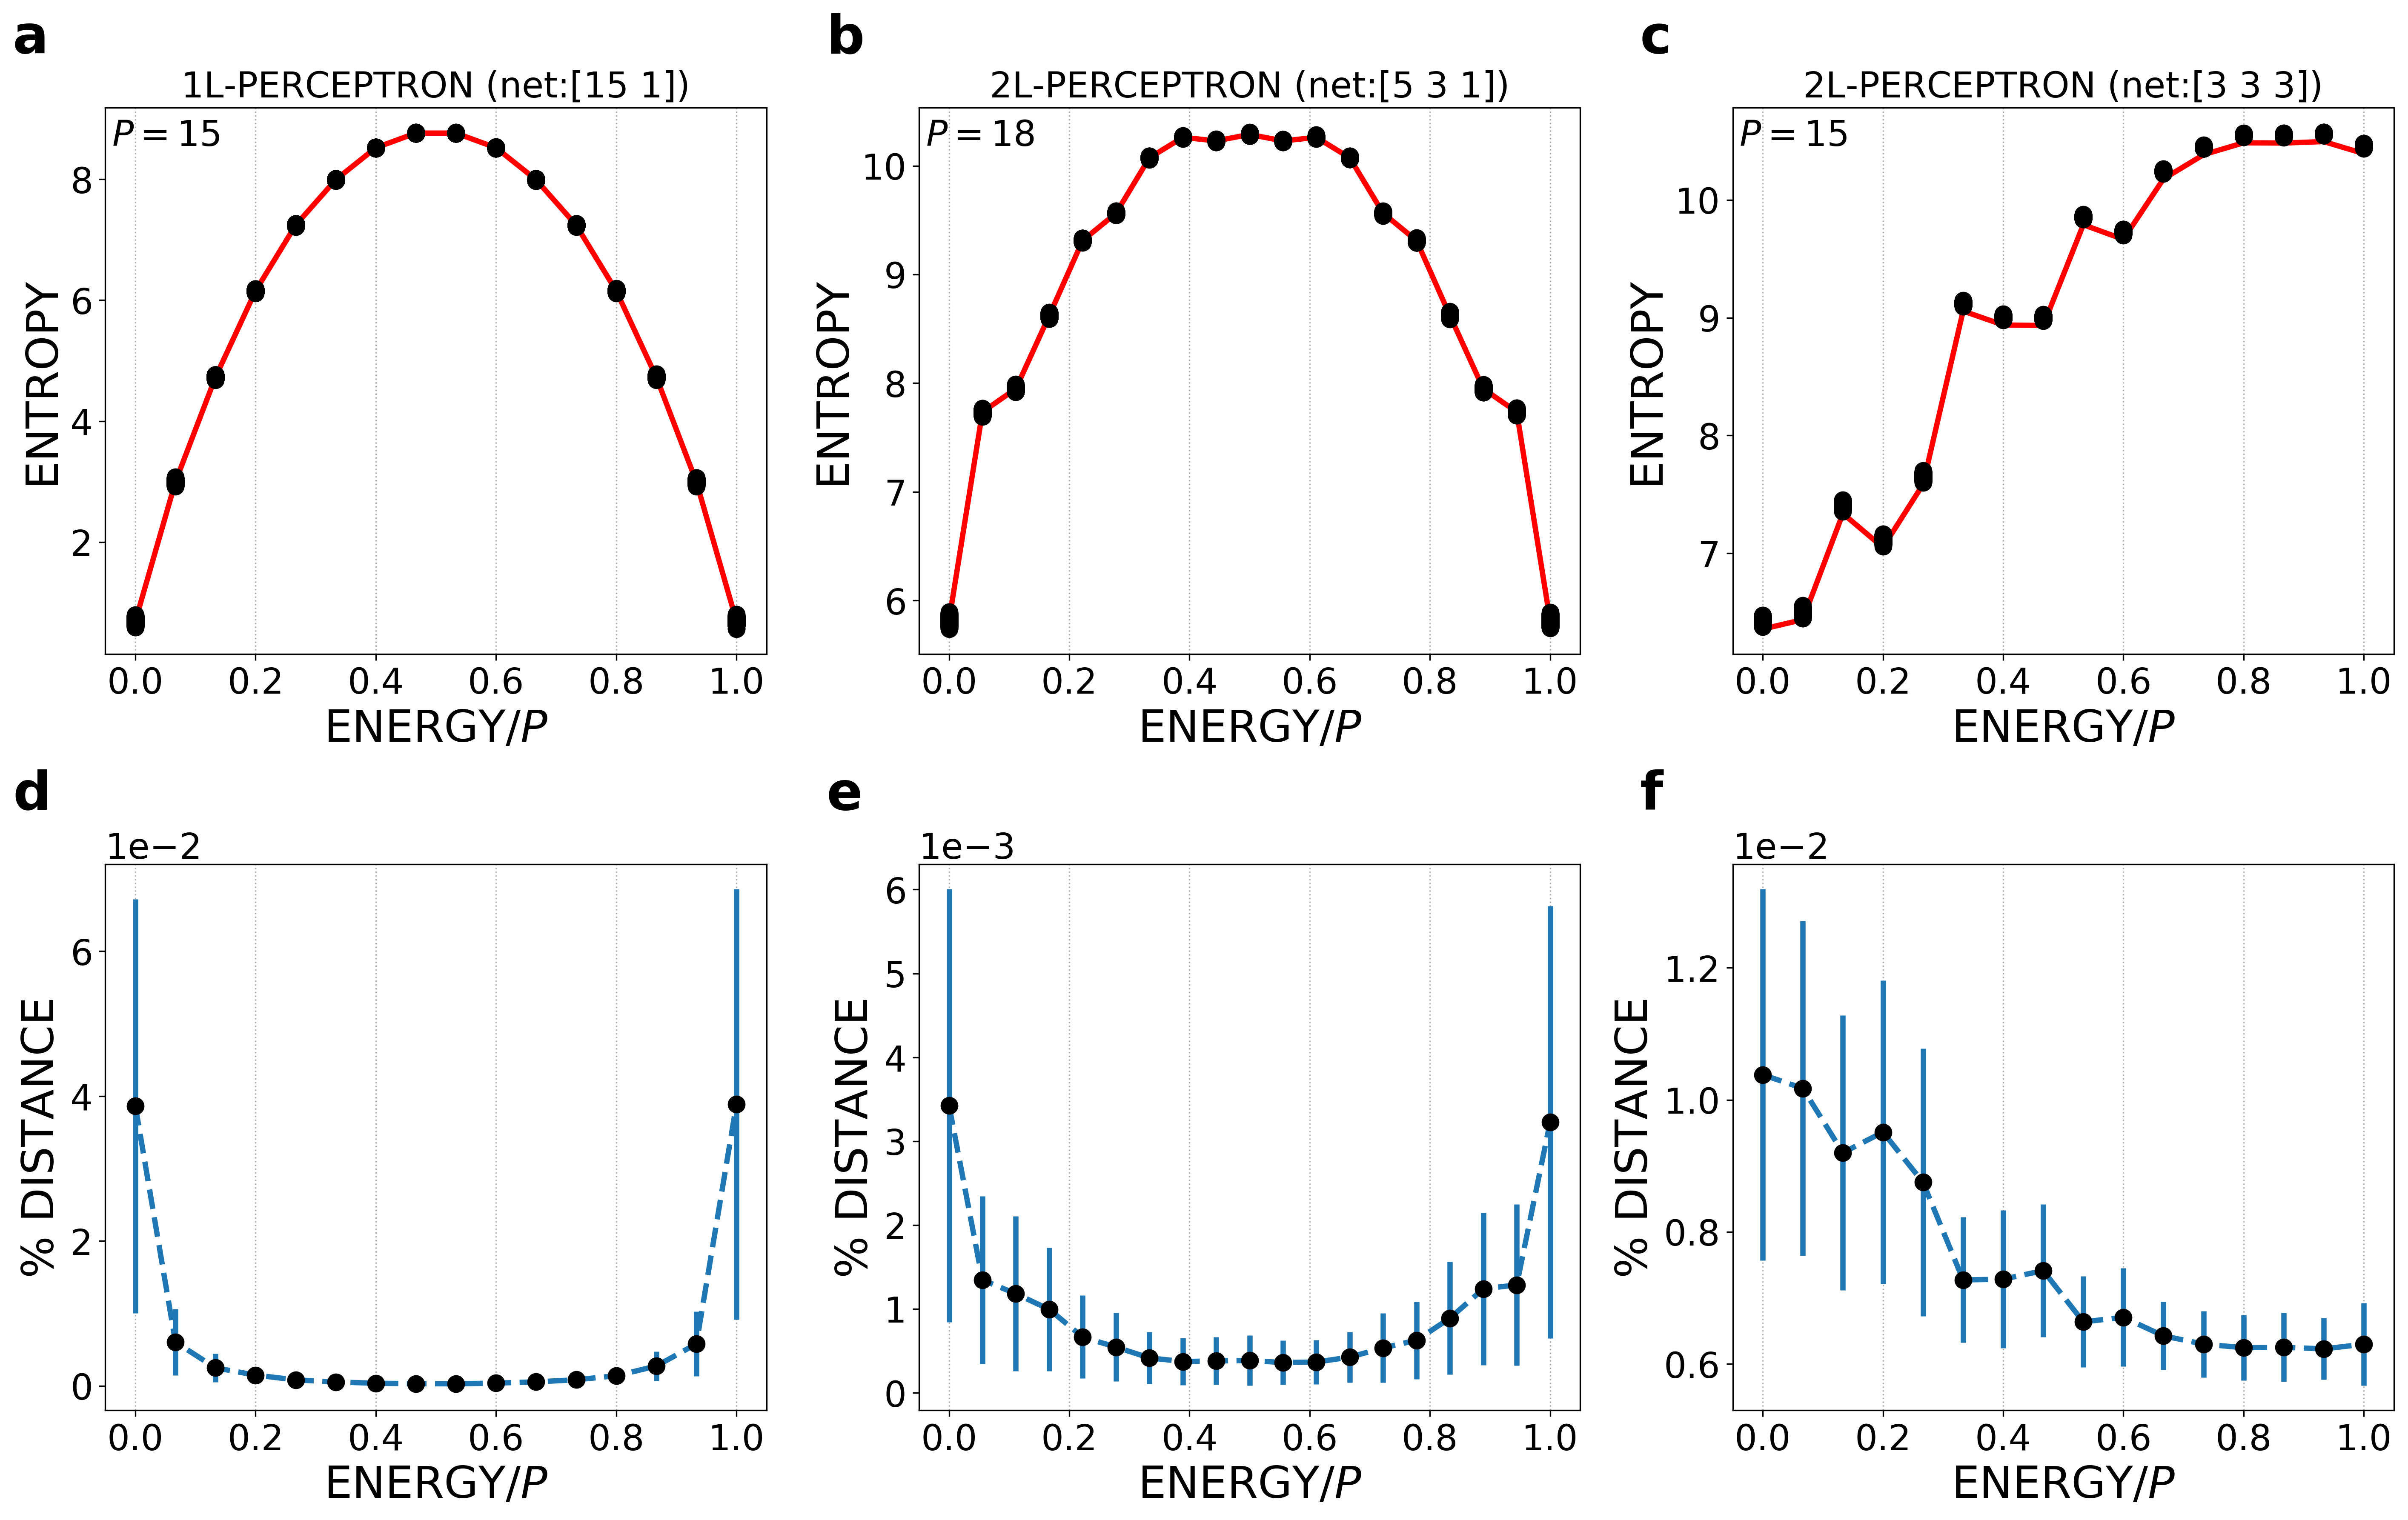

In [54]:
fig, ax= plt.subplots(2,3, figsize=(19,12), dpi=300, sharex=False)
col=[ "#468faf","#01497c","#ae2012","#31572c","#90a955"]
c_cur =  'r' #"#90a955"
c_point= 'k' #"#01497c"
### SILGLE LAYER
ax[0,0].plot(xl_1L/15,np.log(yl_1L), '.-', c=c_cur, lw=3)
for hist in curve_1L:
    ax[0,0].plot(hist[:,0], hist[:,2], 'o', c=c_point, ms=9, mec='k')
    
ax[1,0].errorbar(xl_1L/15, dist_1L.mean(0), yerr=dist_1L.std(0,ddof=1), marker='o', ls='--', mfc='k', mec='k', ms=9, lw=3);    
ax[0,0].text(0.01, 0.93, r"$P = 15 $",fontsize=20, transform=ax[0,0].transAxes)


### MULTILAYER - BINARY
ax[0,1].plot(xl_2L/18,np.log(yl_2L), '-', c=c_cur, lw=3)
for hist in curve_2L:
    ax[0,1].plot(hist[:,0], hist[:,2], 'o', c=c_point, ms=9, mec='k')
    
ax[1,1].errorbar(xl_2L/18, dist_2L.mean(0), yerr=dist_2L.std(0,ddof=1), marker='o', ls='--', mfc='k', mec='k', ms=9, lw=3);    
ax[0,1].text(0.01, 0.93, r"$P = 18 $",fontsize=20, transform=ax[0,1].transAxes)


### MULTILAYER - NOT-BINARY

ax[0,2].plot(xl_2L_O3/15,np.log(yl_2L_O3), '-', c=c_cur, lw=3)
for hist in curve_2L_O3:
    ax[0,2].plot(hist[:,0], hist[:,2], 'o', c=c_point, ms=9, mec='k')

ax[1,2].errorbar(xl_2L_O3/15, dist_2L_O3.mean(0), yerr=dist_2L_O3.std(0,ddof=1), marker='o', ls='--', mfc='k', mec='k', ms=9, lw=3);    
ax[0,2].text(0.01, 0.93, r"$P = 15 $",fontsize=20, transform=ax[0,2].transAxes)


## AXES FONTSIZE & STYLE
[ax[i,j].tick_params(axis='both', which='major', labelsize=20) for i in range(2) for j in range(3)]
[ax[1,j].ticklabel_format(axis='y', style='sci', scilimits=(0,1)) for j in range(3)]
[ax[1,j].yaxis.offsetText.set_fontsize(20) for j in range(3)]

## AXES LABELS
[ax[i,j].set_xlabel(r"ENERGY/$P$", fontsize=25)  for i in range(2) for j in range(3) ] 
[ax[0,j].set_ylabel("ENTROPY", fontsize=25) for j in range(3) ] 
[ax[1,j].set_ylabel("% DISTANCE", fontsize=25) for j in range(3) ] 


### GRID
[ax[i,j].grid(True, axis='x', which='both', lw=0.8, ls=':') for i in range(2) for j in range(3)]

## TITLES
ax[0,0].set_title("1L-PERCEPTRON (net:[15 1])", fontsize=20)
ax[0,1].set_title("2L-PERCEPTRON (net:[5 3 1])", fontsize=20)
ax[0,2].set_title("2L-PERCEPTRON (net:[3 3 3])", fontsize=20)

#LETTERS
[ax[0,i].text(-0.14, 1.1, string.ascii_lowercase[i], transform=ax[0,i].transAxes, size=30, weight='heavy') for i in range(3)] 
[ax[1,i].text(-0.14, 1.1, string.ascii_lowercase[3+i], transform=ax[1,i].transAxes, size=30, weight='heavy') for i in range(3)] 

plt.tight_layout()


Comparison of the true entropy curve to the output of the Wang-Landau algorithm across different network architectures. For each architecture, 500 independent simulations are performed on the same dataset composed of \( P \) data points. 

The upper panels (a-c) compare the true entropy curve (red-solid line) with the sampled ones (black points). The lower panels (d-f) show the mean percentage difference between the true and sampled entropy curves, with associated errors.

**(a)** Single layer perceptron with 15 input neurons and \( P = 15 \).  
**(b)** Two-layer perceptron for binary classification with 5 input neurons, 3 hidden neurons, and \( P = 18 \).  
**(c)** Two-layer perceptron for multi-class classification with 3 input neurons, 3 hidden neurons, 3 output neurons, and \( P = 15 \). 

The corresponding lower panels (d, e, f) illustrate the mean value of the percentage difference between the true and sampled entropy curves with the associated error bars.


## SCALING
#### As a function of the network size at fixed learning rate
Increase the network size and compute the average convergence time of the WL_simulation performed on single core.

The learning rate (P/N) is fixed at 1

#### Data generation 

In [55]:
def model_fit(x, a, b, ):
    #return a * np.exp(b * N)
    return a * x**b 

In [56]:
seeds = [2, 105, 876,273894, 597120, 431689, 849205, ]
Ns = [15, 25, 51, 81, 101]

In [57]:
for random_seed in seeds:
    for n_samples in Ns:
        # Define layer sizes for a single-layer MLP
        layer_sizes_1L = [n_samples, 1]
        
        # Generate synthetic data using the new function structure
        X_s, Y_s, weights_s = generate_synthetic_data(n_samples, layer_sizes_1L, random_seed)
        
        # Save input and output data to files
        # np.savetxt(f"data/SCALING/input_1L_N{n_samples}_P{n_samples}_s{random_seed}.dat", X_s)
        # np.savetxt(f"data/SCALING/output_1L_N{n_samples}_P{n_samples}_s{random_seed}.dat", Y_s)

#### Loading results

In [60]:
Ctime=np.array([[np.loadtxt(f"results/SCALING/Ctime_N{n}_s{s}.txt") for s in seeds] for n in Ns])

In [61]:
# Perform the curve fitting
poptN, pcovN = curve_fit(model_fit, Ns, Ctime.mean(2).mean(1), sigma=1/Ctime.mean(2).std(1))

N_fit = np.linspace(min(Ns), 120, 100)
a_optN, b_optN = poptN

In [62]:
ss_res_Ns = np.sum((Ctime.mean(2).mean(1) - model_fit(Ns, * poptN)) ** 2)
ss_tot_Ns = np.sum((Ctime.mean(2).mean(1) - np.mean(Ctime.mean(2).mean(1))) ** 2)
r_squared_Ns = 1 - (ss_res_Ns / ss_tot_Ns)

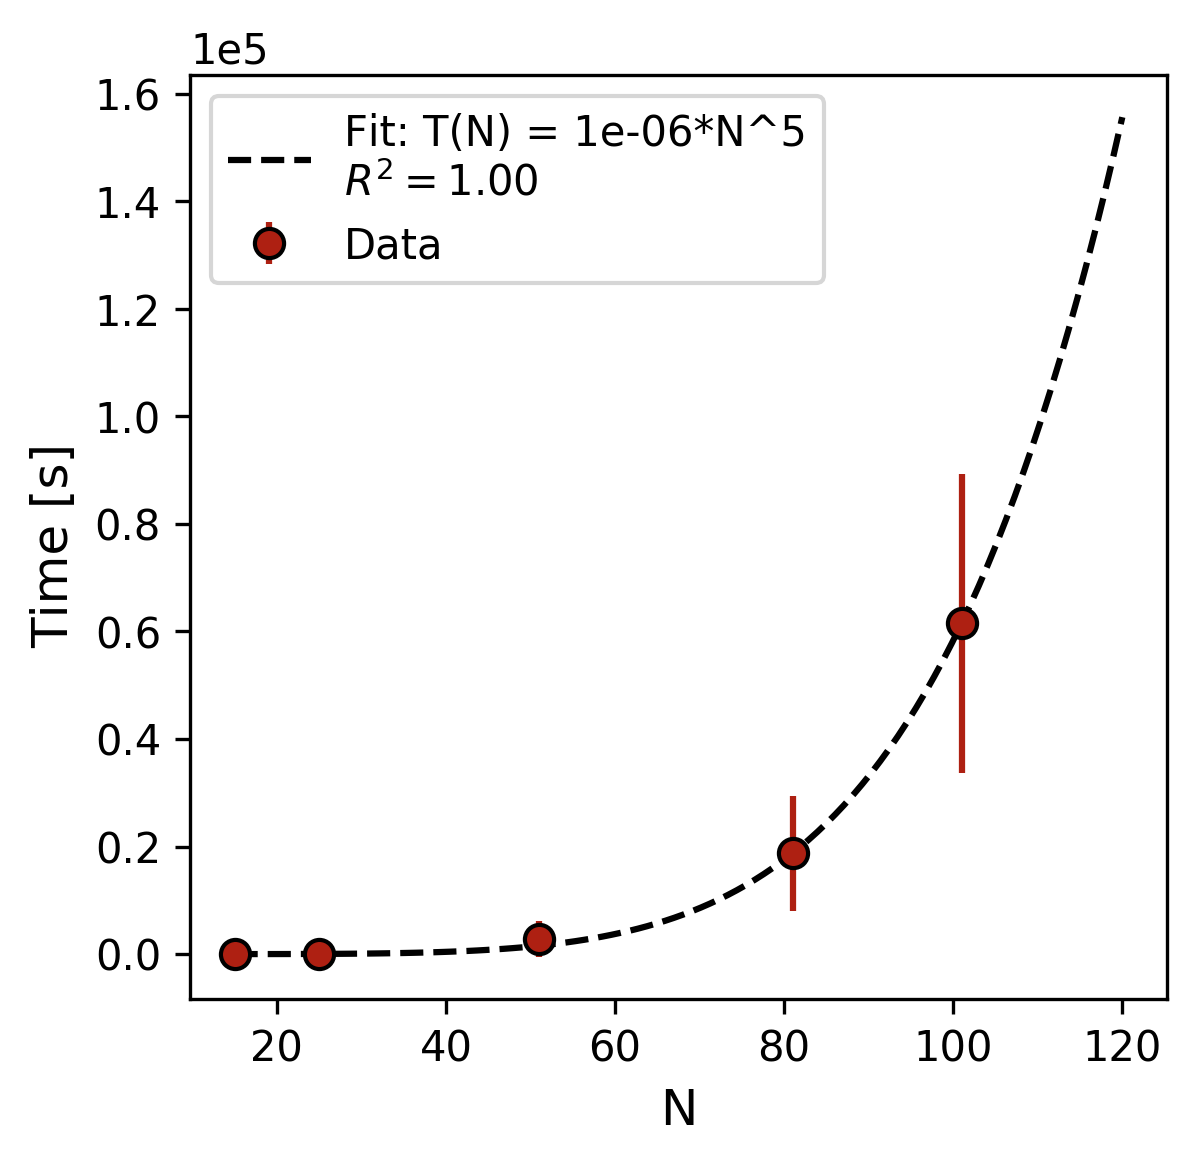

In [63]:
fig, ax= plt.subplots(1,1, figsize=(4.2,4), dpi=300, sharex=False)

plt.errorbar(Ns, Ctime.mean(2).mean(1), yerr=Ctime.mean(2).std(1), ls='',marker='o', c='#ae2012', mec='k', ms=7, label = "Data")
plt.plot(N_fit, model_fit(N_fit, *poptN), ls='--', c='k', label=f'Fit: T(N) = {a_optN:.0e}*N^{b_optN:.0f}\n$R^2={r_squared_Ns:.2f}$')



ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1))
ax.set_xlabel(r"N", fontsize=12)
ax.set_ylabel(r"Time [s] ", fontsize=12)

plt.legend()

#### As a function of the learning rate at fixed network size
The network size is kept fixed at N=100 and the number of samples P has been varied

In [64]:
seeds = [2, 105, 876, 273894, 597120, 431689, 849205]
Ps = [10, 20, 30, 50, 80]

In [65]:
for random_seed in seeds:
    for n_samples in Ps:
        # Define layer sizes for a single-layer MLP
        layer_sizes_1L = [101, 1]
        
        # Generate synthetic data using the new function structure
        X_s, Y_s, weights_s = generate_synthetic_data(n_samples, layer_sizes_1L, random_seed)
        
        # Save input and output data to files
        # np.savetxt(f"data/SCALING/input_1L_N101_P{n_samples}_s{random_seed}.dat", X_s)
        # np.savetxt(f"data/SCALING/output_1L_N101_P{n_samples}_s{random_seed}.dat", Y_s)

In [66]:
Ctime_alpha=np.array([[np.loadtxt(f"results/SCALING/Ctime_N101_P{p}_s{s}.txt") for s in seeds] for p in Ps]+[[np.loadtxt(f"results/SCALING/Ctime_N101_s{s}.txt") for s in seeds]])

In [67]:
# Perform the curve fitting
poptP, pcovP = curve_fit(model_fit, Ps+[101], Ctime_alpha.mean(2).mean(1), sigma=1/Ctime_alpha.mean(2).std(1),)

P_fit = np.linspace(min(Ps), 120, 100)
a_optP, b_optP = poptP

In [68]:
ss_res_P = np.sum((Ctime_alpha.mean(2).mean(1) - model_fit(Ps+[101], * poptP)) ** 2)
ss_tot_P = np.sum((Ctime_alpha.mean(2).mean(1) - np.mean(Ctime_alpha.mean(2).mean(1))) ** 2)
r_squared_P = 1 - (ss_res_P / ss_tot_P)

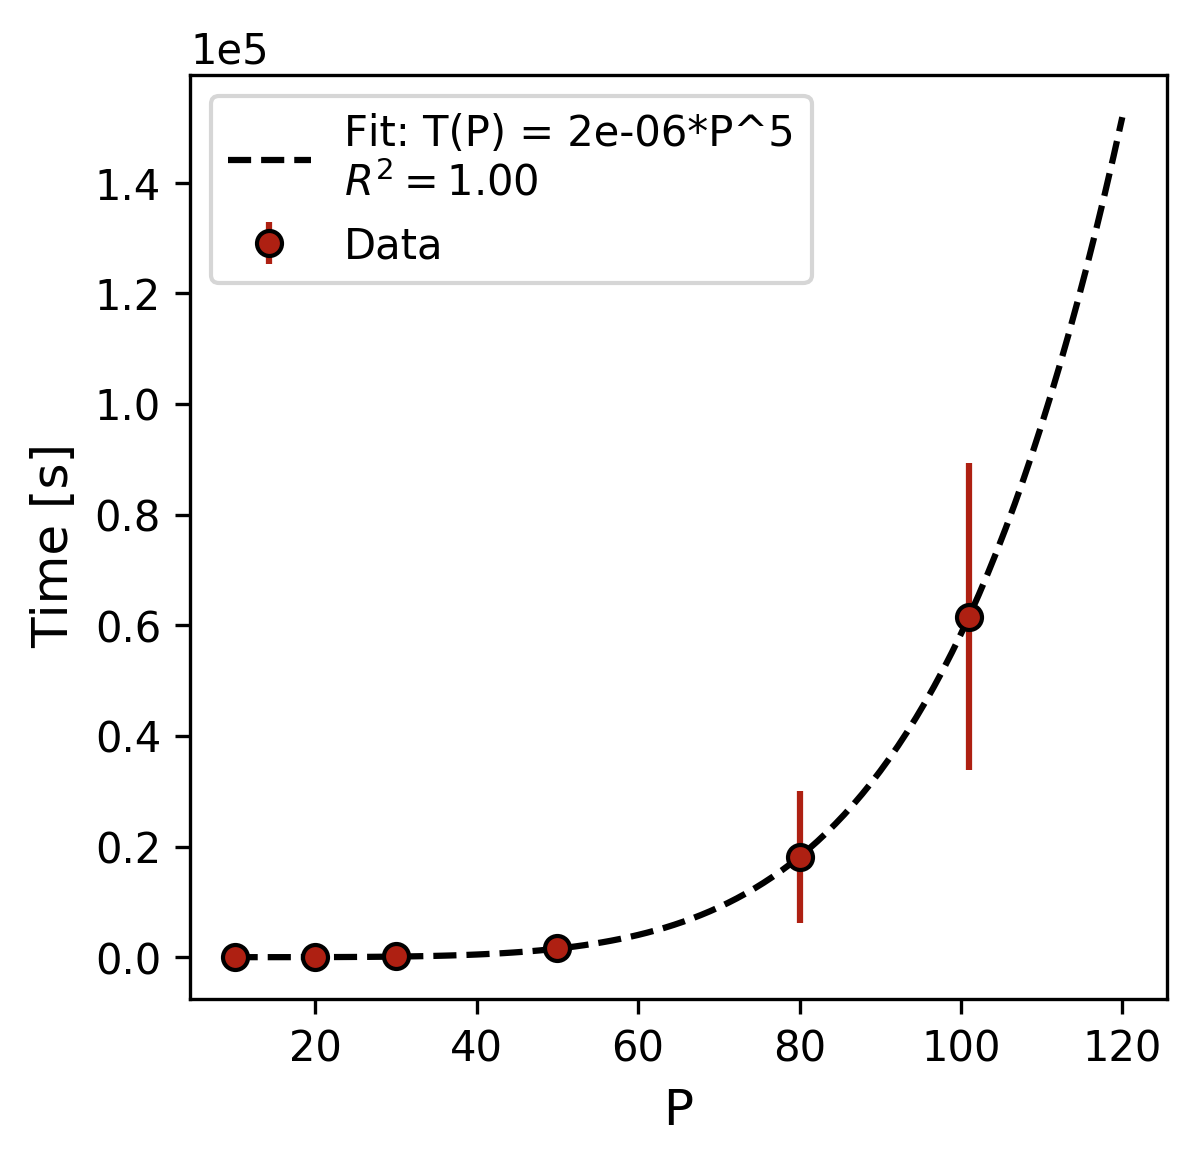

In [69]:
fig, ax= plt.subplots(1,1, figsize=(4.2,4), dpi=300, sharex=False)
plt.errorbar(Ps+[101], Ctime_alpha.mean(2).mean(1), yerr=Ctime_alpha.mean(2).std(1), marker= 'o', ls='',c='#ae2012',label = "Data", mec='k' )
plt.plot(P_fit, model_fit(P_fit, *poptP), ls='--', c='k', label=f'Fit: T(P) = {a_optP:.0e}*P^{b_optP:.0f}\n$R^2={r_squared_P:.2f}$')


ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1))
ax.set_xlabel(r"P", fontsize=12)
ax.set_ylabel(r"Time [s] ", fontsize=12)
plt.legend(loc="upper left")

#### Complete plot

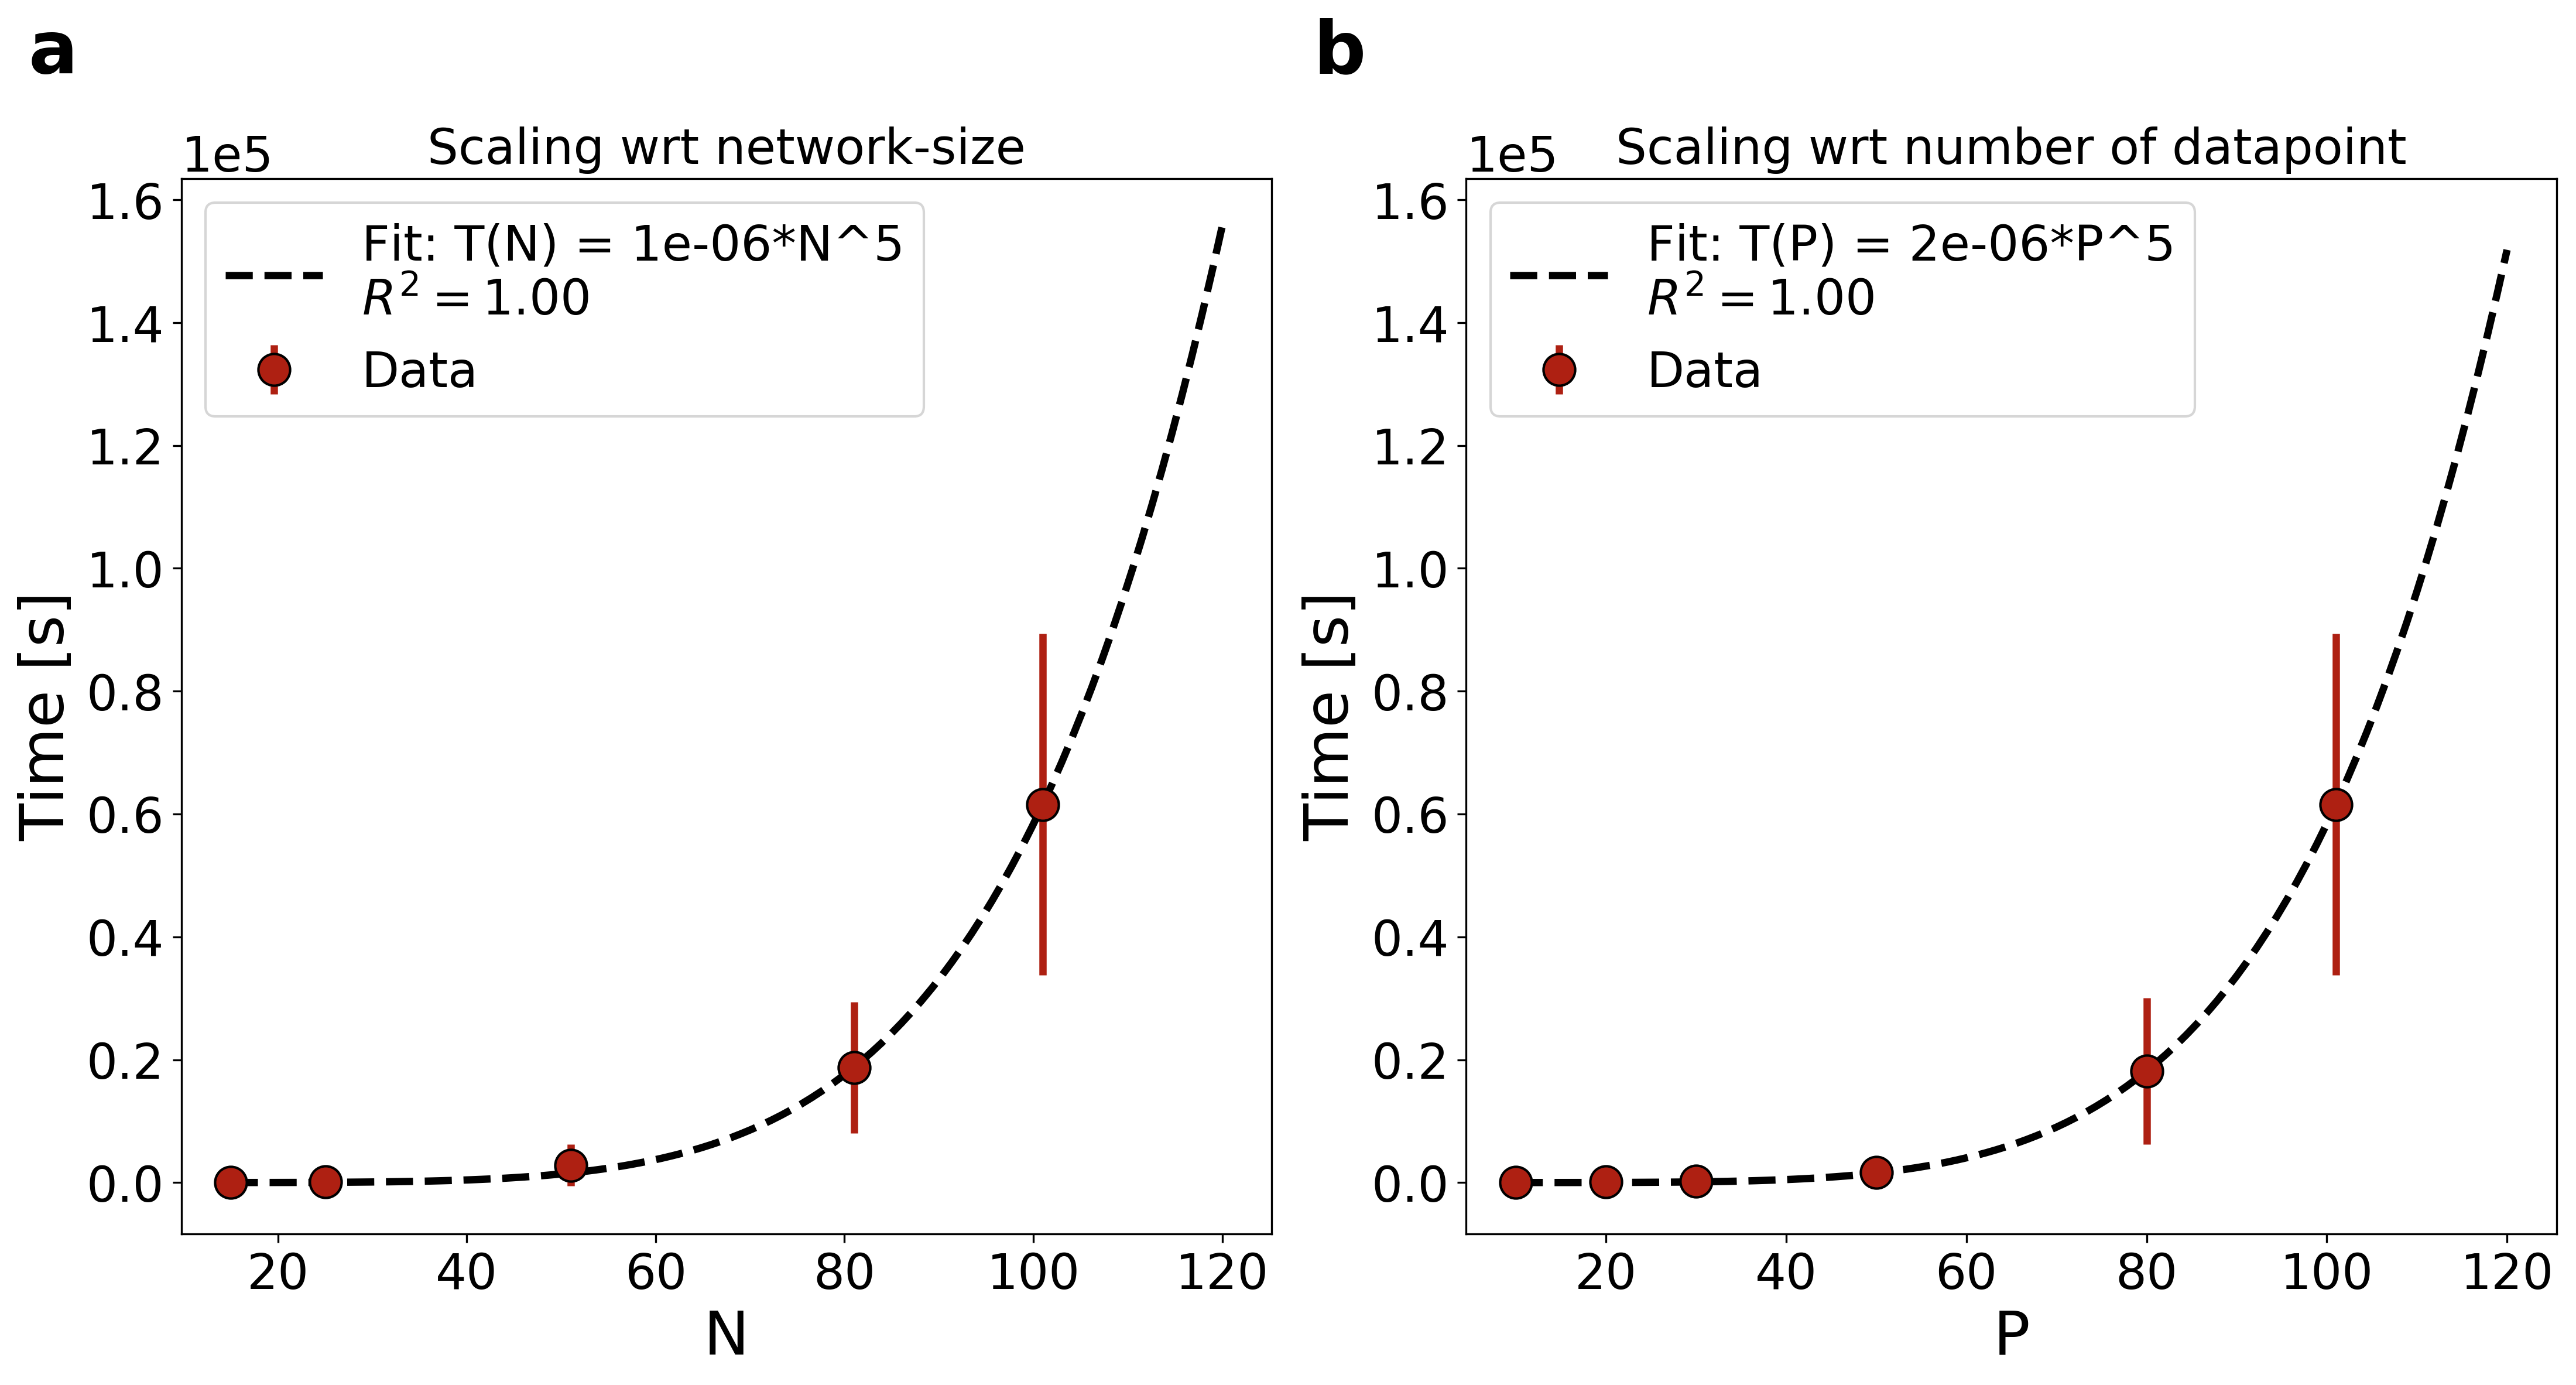

In [70]:
fig, ax= plt.subplots(1,2, figsize=(15,8), dpi=300, sharey=False)


ax[0].errorbar(Ns, Ctime.mean(2).mean(1), yerr=Ctime.mean(2).std(1), ls='',marker='o', c='#ae2012', mec='k', ms=13, lw=3,label = "Data")
ax[0].plot(N_fit, model_fit(N_fit, *poptN), ls='--', c='k', label=f'Fit: T(N) = {a_optN:.0e}*N^{b_optN:.0f}\n$R^2={r_squared_Ns:.2f}$', lw=3)



ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,1))
ax[0].set_xlabel(r"N", fontsize=25)
ax[0].set_ylabel(r"Time [s] ", fontsize=25)
ax[0].legend(fontsize=20)

ax[0].set_title("Scaling wrt network-size", fontsize=20)

###################
ax[1].errorbar(Ps+[101], Ctime_alpha.mean(2).mean(1), yerr=Ctime_alpha.mean(2).std(1), marker= 'o', ls='',c='#ae2012',label = "Data", mec='k', lw=3 ,ms=13 )
ax[1].plot(P_fit, model_fit(P_fit, *poptP), ls='--', c='k', label=f'Fit: T(P) = {a_optP:.0e}*P^{b_optP:.0f}\n$R^2={r_squared_P:.2f}$', lw=3)


ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,1))
ax[1].set_xlabel(r"P", fontsize=25)
ax[1].set_ylabel(r"Time [s] ", fontsize=25)
ax[1].legend(loc="upper left",fontsize=20)
ax[1].set_title("Scaling wrt number of datapoint", fontsize=20)



###############

[ax[i].tick_params(axis='both', which='major', labelsize=20) for i in range(2)]
[ax[i].text(-0.14, 1.1, string.ascii_lowercase[i], transform=ax[i].transAxes, size=30, weight='heavy') for i in range(2)]
[ax[i].yaxis.offsetText.set_fontsize(20) for i in range(2)];



ax[1].set_ylim(ax[0].get_ylim())

plt.tight_layout()

#### Convergence Time of the Wang-Landau Algorithm Executed on a Single Core as a Function of Network Size and Learning Complexity

**(a)** The scaling of convergence time with respect to the number of neurons \(N\) in a single-layer perceptron, at a fixed learning complexity \(\alpha = \frac{P}{N} = 1\). For each value of \(N\), 7 independent datasets were generated, and for each dataset, 50 independent simulations were performed. The data points represent the mean convergence time, and the dashed line represents the fitted curve with \(T(N) = 10^{-6} N^5\).

**(b)** The convergence time as a function of the learning complexity \(\alpha\), at a fixed number of neurons \(N = 100\). Similarly, 7 datasets were generated for each value of \(P\), and 50 independent simulations were conducted per dataset. The fitted curve is \(T(P) = 2 \times 10^{-6} P^5\).


## Gaussian Fit

In [71]:
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(- (x - mu)**2 / (2 * sigma**2))

In [72]:
## Load the curves
Nrand=[251, 501, 1001]
curves_rand=np.array([load_curves(f"RANDOM{N}", "", "",  N, rescale=True)[0] for N in Nrand])


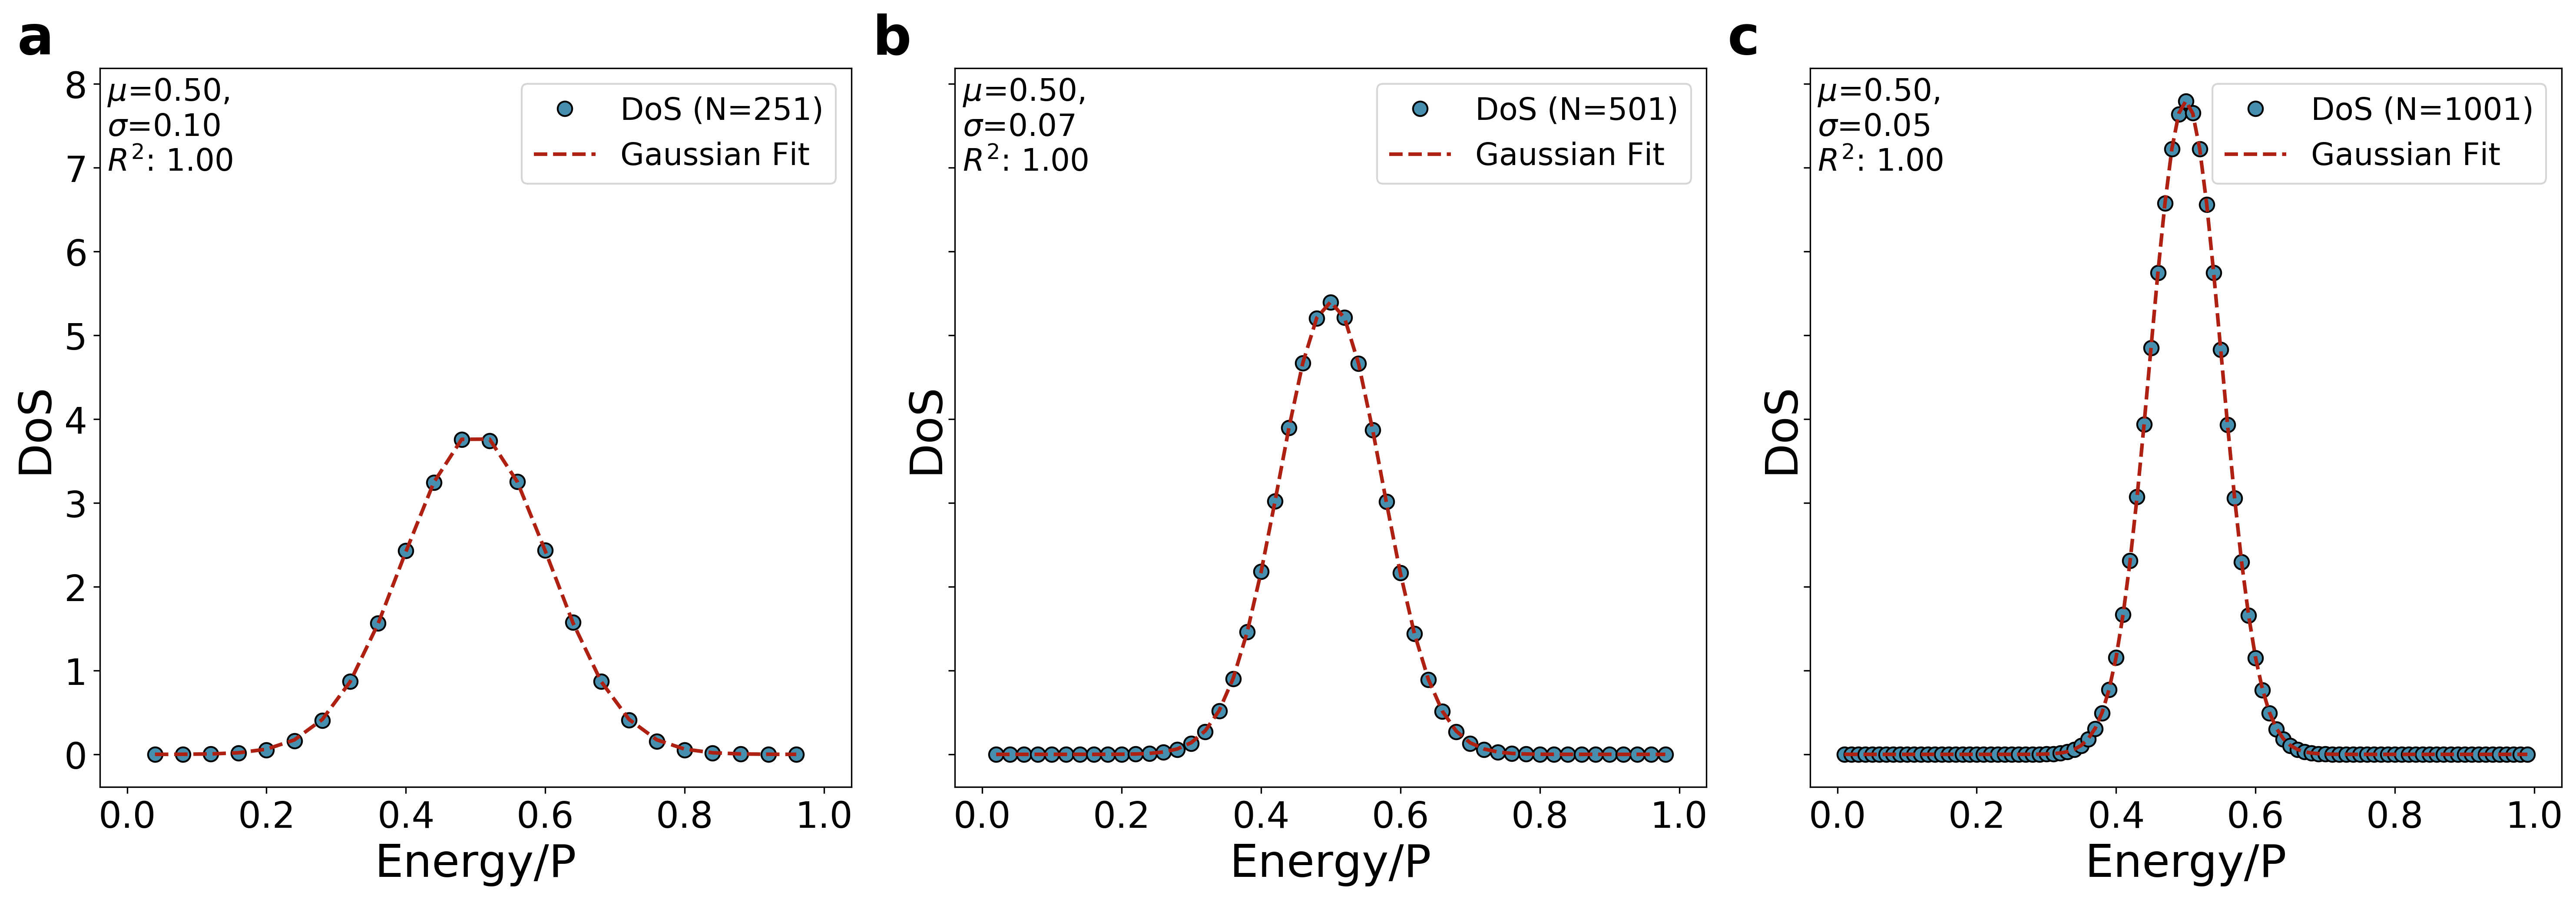

In [73]:
col=[ "#468faf","#01497c","#ae2012","#31572c","#90a955"]

fig, ax =plt.subplots(1,3,figsize=(20, 7), sharex=True, sharey=True, dpi=300)
for i in range(3):
    DEL=1
    x=curves_rand[i][DEL:-DEL,0]
    dos=curves_rand[i][DEL:-DEL,1]
    initial_guess = [max(dos), np.mean(x), np.std(x)]

    # Fit the Gaussian model to the DOS data
    params, covariance = curve_fit(gaussian, x, dos, p0=initial_guess)
    # Extract the parameters
    amp, mu, sigma = params
    
    fitted_gaussian = gaussian(x, *params)
    
    # Calculate the R-squared value
    ss_res = np.sum((dos - fitted_gaussian) ** 2)
    ss_tot = np.sum((dos - np.mean(dos)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the original DOS and the Gaussian fit
    ax[i].plot(x, dos, 'o', ms=8,mec='k', c = col[0], label=f'DoS (N={Nrand[i]})')
    ax[i].plot(x, fitted_gaussian, '--', c = col[2], lw=2, label=f'Gaussian Fit')
    ax[i].text(0.01, 0.99, f'$\mu$={mu:.2f},\n$\sigma$={sigma:.2f}\n$R^2$: {r_squared:.2f}',fontsize=17, transform=ax[i].transAxes, va="top",)
    
    
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].set_xlabel('Energy/P', fontsize=25)
    ax[i].set_ylabel('DoS', fontsize=25)
    ax[i].legend(fontsize=17)
    
    ax[i].text(-0.11, 1.02, string.ascii_lowercase[i], transform=ax[i].transAxes, size=30, weight='heavy')

    
plt.tight_layout()

#### Density of States Curves for Binary Classification by a Single-Layer Perceptron and Gaussian Fit

Each panel presents the density of states for binary classification of random data using a single-layer perceptron with different numbers of input layer neurons, $N$, as specified in the legend. The top left corner of each plot provides the parameters of the Gaussian fit, including the standard deviation ($\sigma$) and the mean ($\mu$), as well as the coefficient of determination ($R^2$).


## Fashion-MNIST

In [74]:
## Load the curves
data="FashionMNIST"
key_s="a01u_P1"
P1=[9,21,39, 57,69]
curves=np.array([load_curves(data, key_s, f"_{p1}",  784, rescale=True)[0] for p1 in P1])

P1_b=[27,99,196, 293, 365 ]
key_s="a05u_P1"
curves_b=np.array([load_curves(data, key_s, f"_{p1}",  784, rescale=True)[0] for p1 in P1_b])

In [75]:
## Find the peak location
#a=0.1
data="FashionMNIST"
key_s="a01u_P1"
P1_c=np.array([3,9,15,21,27, 33,39,45, 51, 57,63,69,75])
curves_c=np.array([load_curves(data, key_s, f"_{p1}",  784, rescale=True)[0] for p1 in P1_c])
peak_loss=[]
for hist in curves_c:
    loc_l= np.argmax(hist[:int(hist.shape[0]/2)+1,1])
    peak_loss.append(hist[loc_l, 0])
    
#a=1    
P1_c_b = np.array([3,  15,  27,  39,  51,  63,  75,  87,  99, 111, 123, 135, 147,
       159, 171, 183, 195, 196, 197, 209, 221, 233, 245, 257, 269, 281, 293,
       305, 317, 329, 341, 353, 365, 377, 389])
key_s="a05u_P1"
curves_c_b=np.array([load_curves(data, key_s, f"_{p1}",  784, rescale=True)[0] for p1 in P1_c_b])

peak_loss_b=[]
for hist in curves_c_b:
    loc_l= np.argmax(hist[:int(hist.shape[0]/2)+1,1])
    peak_loss_b.append(hist[loc_l, 0])

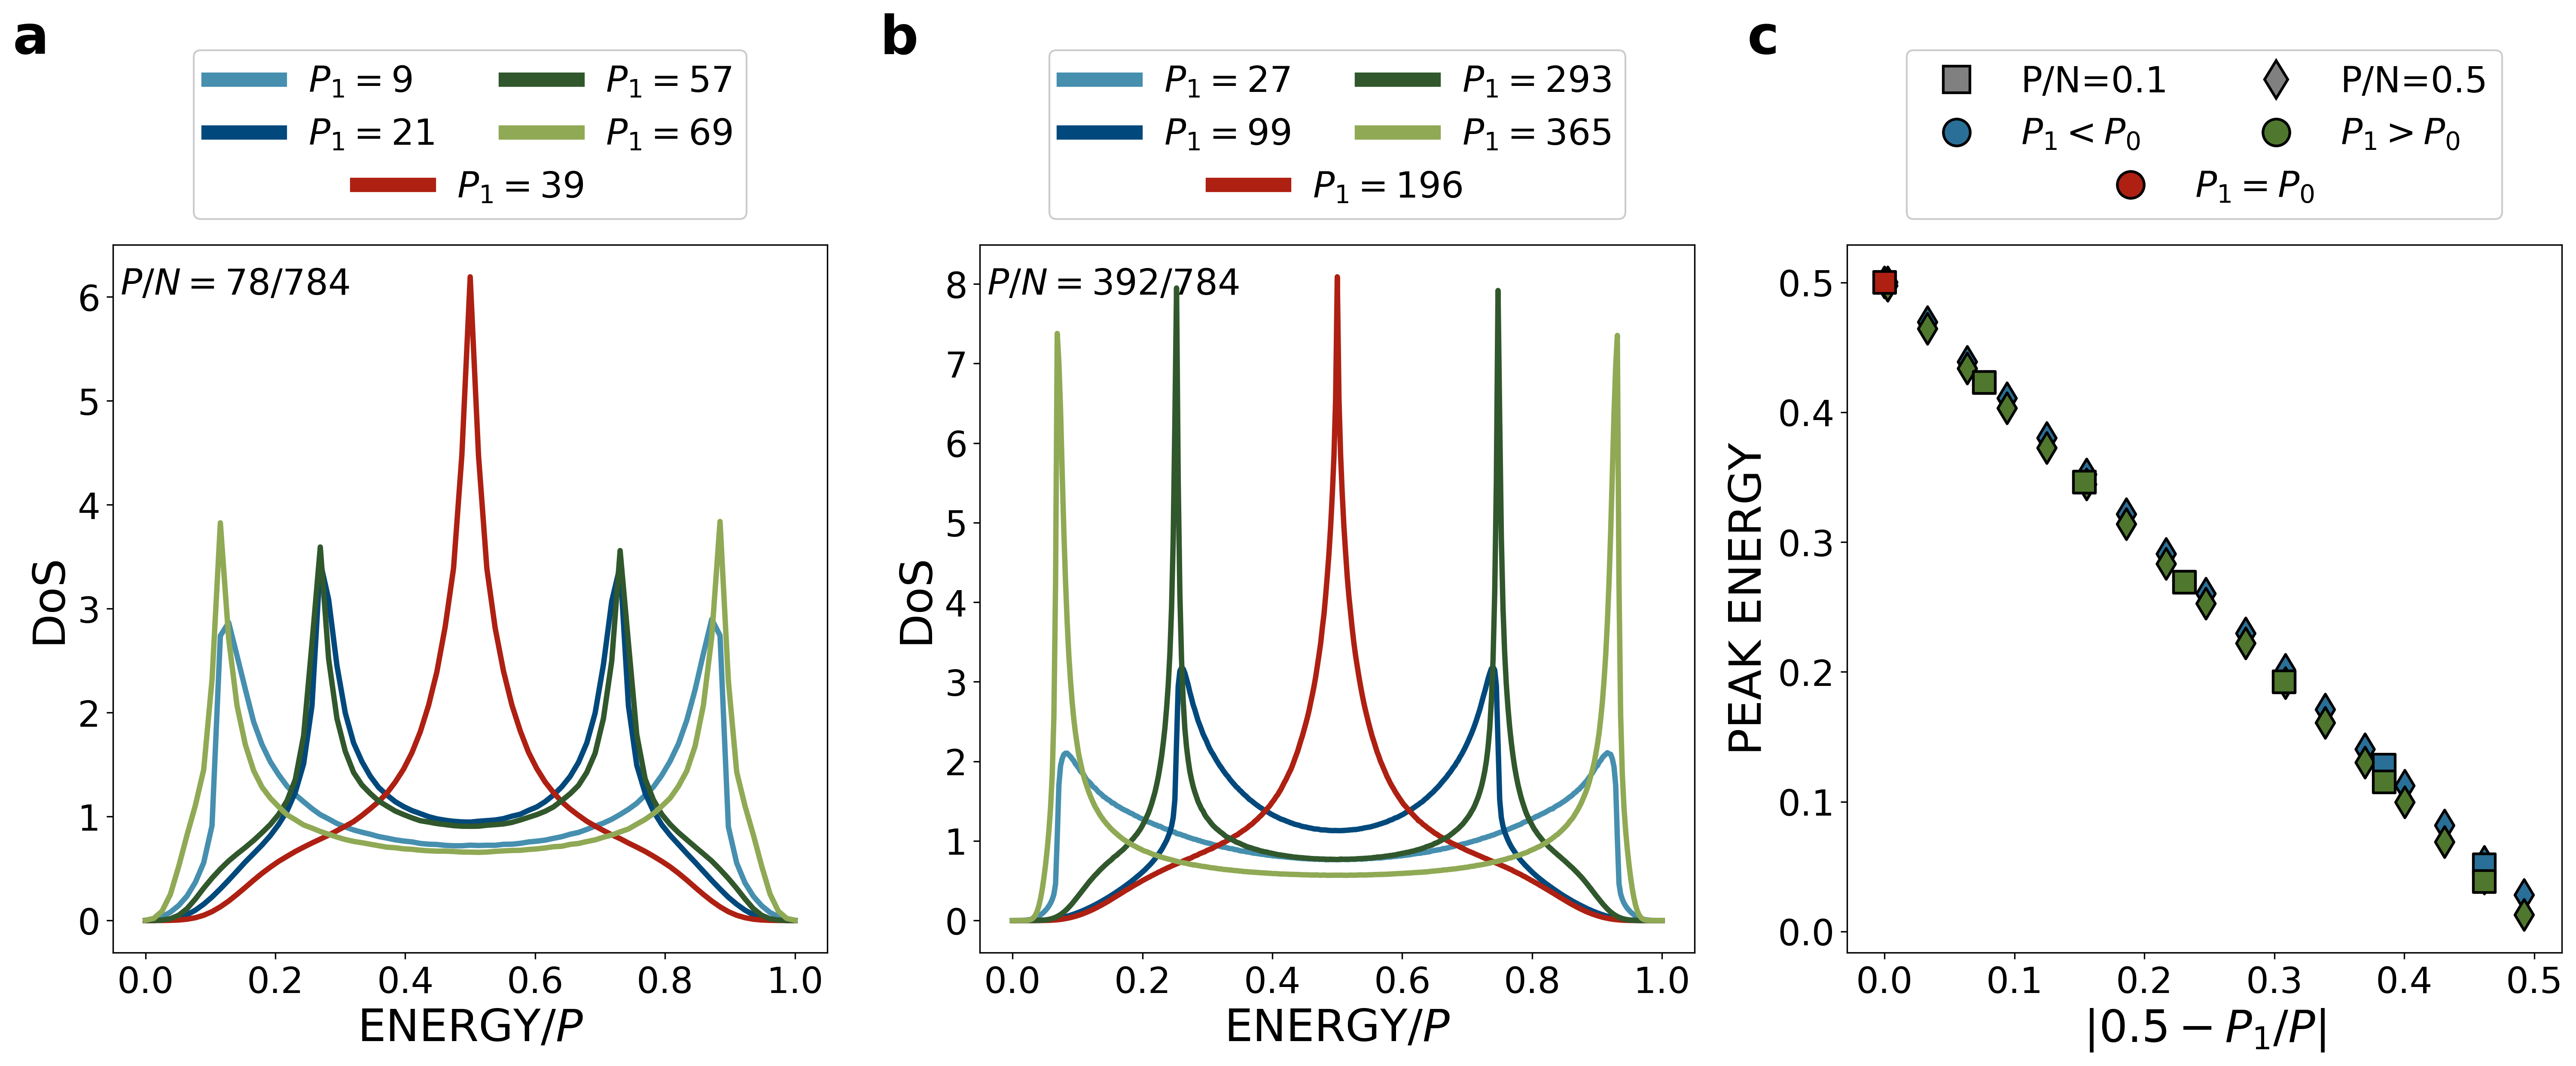

In [76]:
## colors and legend handles
col=[ "#468faf","#2a6f97","#01497c","#ae2012","#31572c","#4f772d","#90a955"] ## 7 curves
col=[ "#468faf","#01497c","#ae2012","#31572c","#90a955"] ## 5 curves
col1=["#2a6f97"]*6+["#ae2012"]+["#4f772d"]*6 ## scatter plot
col1_b=["#2a6f97"]*17+["#ae2012"]+["#4f772d"]*17 ## scatter plot
lab=[r"$P_1<P_0$", r"$P_1>P_0$", r"$P_1=P_0$"]

legend_handles=[plt.Line2D([0], [0], ls='-', lw=8 ,color= col[i], label=fr"$P_1={P1[i]}$") for i in [0,1,3,4]] 
legend_handles_1=[plt.Line2D([0], [0], ls='-', lw=8 ,color= col[i], label=fr"$P_1={P1[i]}$") for i in [2]] 

legend_handlesb=[plt.Line2D([0], [0], ls='-', lw=8 ,color= col[i], label=fr"$P_1={P1_b[i]}$") for i in [0,1,3,4]] 
legend_handles_1b=[plt.Line2D([0], [0], ls='-', lw=8 ,color= col[i], label=fr"$P_1={P1_b[i]}$") for i in [2]] 

legend_handles1=[plt.Line2D([0], [0], ls='', marker="s", ms=15, mec='k', mew=1.5,color= "gray", label="P/N=0.1")] + [plt.Line2D([0], [0], ls='',
                            marker="o", ms=15, mec='k', mew=1.5,color= np.unique(col1)[i], label=lab[i]) for i in [0]] + [plt.Line2D([0], [0], ls='', 
                            marker="d", ms=15, mec='k', mew=1.5,color= "gray", label="P/N=0.5")] + [plt.Line2D([0], [0], ls='', marker="o", ms=15, mec='k', mew=1.5,color= np.unique(col1)[i], label=lab[i]) for i in [1]]

legend_handles2=[plt.Line2D([0], [0], ls='', marker="o", ms=15, mec='k', mew=1.5,color= np.unique(col1)[i], label=lab[i]) for i in [2]]


fig, ax= plt.subplots(1,3, figsize=(20,8.7), gridspec_kw={'width_ratios':[1,1,1]},dpi=300)

for i in range(5):
    ax[0].plot(curves[i][:,0], curves[i][:,1] , '-',c=col[i], lw=3, )
    ax[1].plot(curves_b[i][:,0], curves_b[i][:,1] , '-',c=col[i], lw=3, )
    
ax[2].scatter(np.abs(0.5-P1_c_b/392), peak_loss_b, marker='d', s=150, edgecolor='k', c =col1_b, lw=1.5,)
ax[2].scatter(np.abs(0.5-P1_c/78), peak_loss, marker='s', s=150, edgecolor='k', c=col1, lw=1.5, )

#### styling
ax[0].text(0.01, 0.93, r"$P/N = 78/784 $",fontsize=20, transform=ax[0].transAxes)
ax[1].text(0.01, 0.93, r"$P/N = 392/784 $",fontsize=20, transform=ax[1].transAxes)

[ax[i].tick_params(axis='both', which='major', labelsize=20) for i in range(3)] 
[ax[i].set_xlabel(r"ENERGY/$P$", fontsize=25)  for i in range(2)]
[ax[i].set_ylabel("DoS", fontsize=25) for i in range(2)]

ax[2].set_xlabel(r"$|0.5- P_1/P|$", fontsize=25)     
ax[2].set_ylabel("PEAK ENERGY", fontsize=25)

## LEGEND
create_combined_legend(ax[0], legend_handles, legend_handles_1, ncol1=2, ncol2=1, bbox=(0.5,1.3))
create_combined_legend(ax[1], legend_handlesb, legend_handles_1b, ncol1=2, ncol2=1, bbox=(0.5,1.3))
create_combined_legend(ax[2], legend_handles1, legend_handles2, ncol1=2, ncol2=1, bbox=(0.5,1.3))

##LETTERS
[ax[i].text(-0.14, 1.27, string.ascii_lowercase[i], transform=ax[i].transAxes, size=30, weight='heavy') for i in range(3)]



plt.tight_layout()


#### Density of States Analysis for Binary Classification of FashionMNIST Images (T-shirt/Top and Trouser) Under Various Class Imbalances

**(a)** Density of states at a fixed learning complexity of $P/N = 0.1$, showing the distribution for different class imbalances. The legend indicates the number of elements in class 1 ($P_1$). Perfect class balance is achieved when $P_1 = P_0 = P/2$ (red curve). Larger deviations from this value indicate greater class imbalance. Blue curves represent a predominance of class 0, while green curves represent a predominance of class 1; the lighter the color, the greater the class imbalance.

**(b)** Density of states at a higher learning complexity of $P/N = 0.5$, showing similar trends with varying class imbalances.

**(c)** Peak energy values plotted against the absolute difference $|0.5 - P_1/P|$, highlighting the correlation between peak energy and class imbalance. Blue points indicate a predominance of class 0, while green points indicate a predominance of class 1. Red points represent perfect balance ($P_1 = P_0$). Results are shown for two values of learning complexity: $P/N = 0.1$ (squares) and $P/N = 0.5$ (diamonds).


## Gaussian Clones

In [77]:
def Angle(a, b):
    """
    Calculate the angle in degrees between two vectors.

    Args:
        a (numpy.ndarray): The first vector.
        b (numpy.ndarray): The second vector.

    Returns:
        float: The angle in degrees between the two vectors.
    """
    return np.degrees(np.arccos((np.dot(a/np.linalg.norm(a) , b / np.linalg.norm(b)) )))

In [79]:
angle=np.loadtxt("../NaNDoS/results/MNIST100/inter-class-mean-angle.dat")

In [143]:
cases = [0, 2, 3, 4, 5, 6, 7, 8, 9]  # Replicates
Δμ_m100 = np.array([0.2, 1.0, 1.5, 2.0])  # Δμ values
P1_m100 = np.linspace(10, 70, 7, dtype=int)  # P1 values
N = 100
P = 80
dat_2ISO = "MNIST100/UNBALANCING_2ISOgm"  # Dataset path
dat_gm = "MNIST100/UNBALANCING_gm"  # Dataset path

# Call the dof_curve function for UNBALANCING_2ISOgm mode
p_l_2ISO, p_r_2ISO = dof_curve(cases, Δμ_m100, P1=P1_m100, N=N, P=P, mode='UNBALANCING_2ISOgm', dat=dat_2ISO)
p_l_gm, p_r_gm = dof_curve(cases, Δμ_m100, P1=P1_m100, N=N, P=P, mode='UNBALANCING_gm', dat=dat_gm)


/apps/Python-3.7.2/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


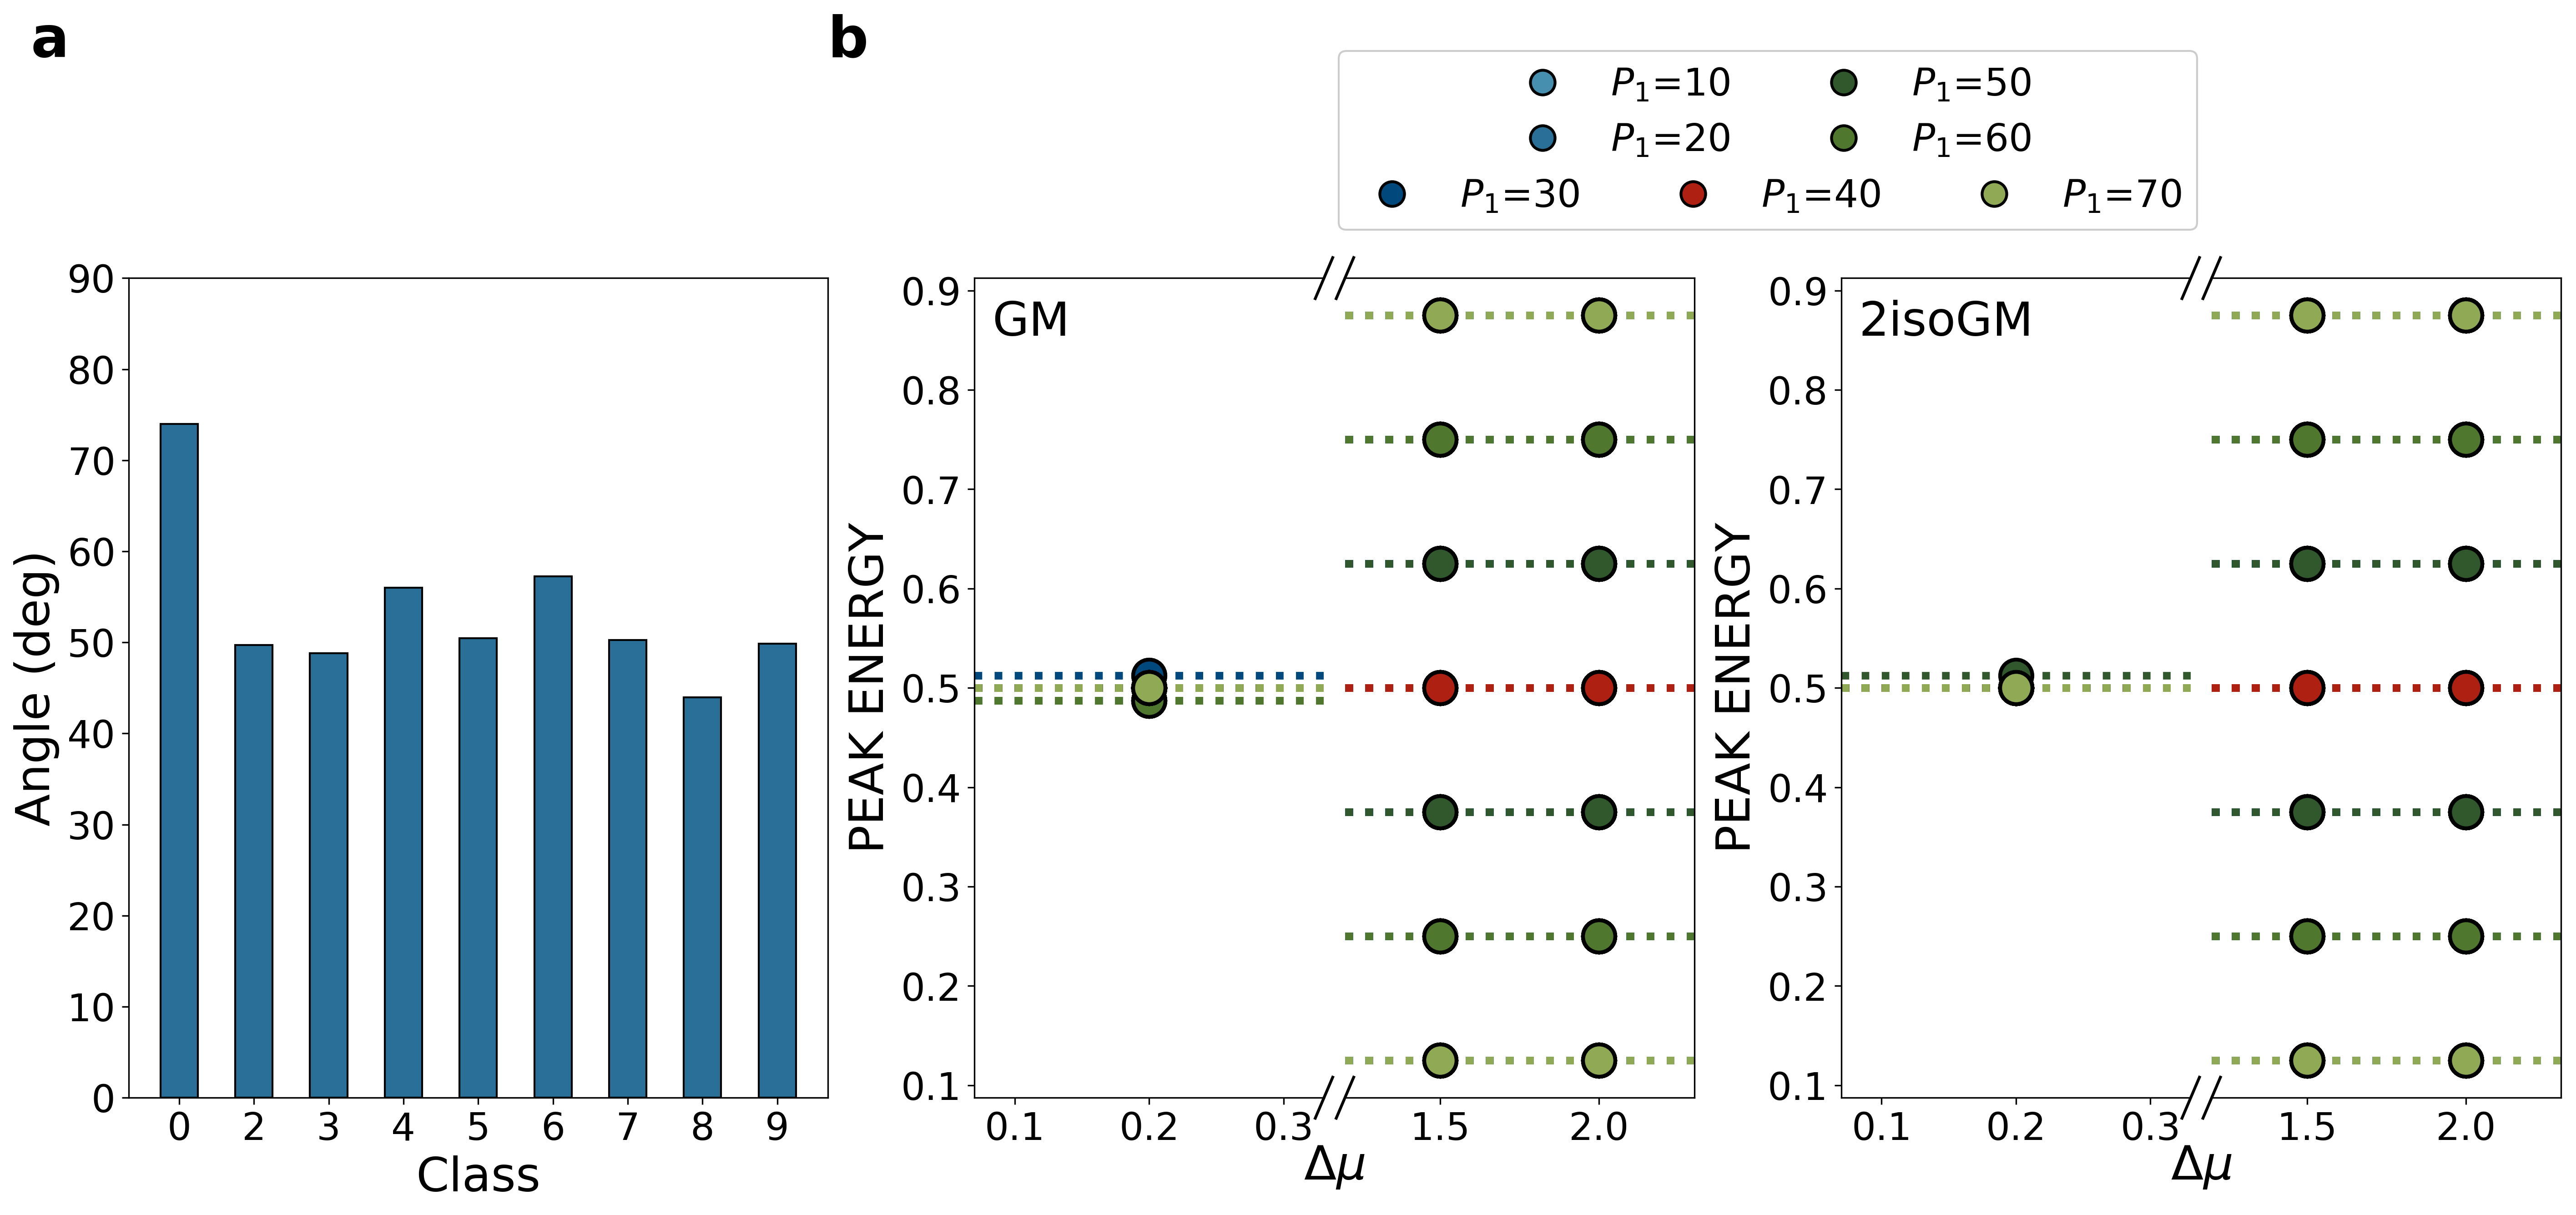

In [144]:
angle_colors = ["#468faf", "#2a6f97", "#01497c", "#ae2012", "#31572c", "#4f772d", "#90a955"]
point_legend_1 = [plt.Line2D([0], [0], ls='', marker="o", ms=13, mec='k', mew=1.5, color=angle_colors[i], label=fr"$P_1$={P1_m100[i]}") for i in [0, 1, 4, 5]]
point_legend_2 = [plt.Line2D([0], [0], ls='', marker="o", ms=13, mec='k', mew=1.5, color=angle_colors[i], label=fr"$P_1$={P1_m100[i]}") for i in [2, 3, 6]]
    

fig, ax= plt.subplots(1,9, figsize=(23,7.8), gridspec_kw={"width_ratios":[1/3, 0.07 ,1/6, 0.01, 1/6, 0.07 ,1/6, 0.01 ,1/6 ], "wspace":0.0}, dpi=300)
invisible_axes = [ax[1], ax[3], ax[5], ax[7]]
for a in invisible_axes:
        a.axis('off')
        
breaking_rules([ax[2], ax[6]], [ax[4], ax[8]], (0.07, 0.33), (1.2, 2.3), xticks_left=[0.1, 0.2, 0.3],xticks_right=[1.5, 2.0,])


### PLOTS ###
ax[0].bar(np.arange(9), angle , 0.5, ec='k',color="#2a6f97")

for i in range(9):
    for j in range(7):
        
        ax[2].axhline(p_l_gm[i, 0, j], ls=':',c=angle_colors[j], lw=4)
        ax[2].axhline(p_r_gm[i, 0, j], ls=':',c=angle_colors[j], lw=4)
        
        ax[6].axhline(p_l_2ISO[i, 0, j], ls=':',c=angle_colors[j], lw=4)
        ax[6].axhline(p_r_2ISO[i, 0, j], ls=':',c=angle_colors[j], lw=4)
        
        

        ax[4].axhline(p_l_2ISO[i, -1, j], ls=':',c=angle_colors[j], lw=4)
        ax[4].axhline(p_r_2ISO[i, -1, j], ls=':',c=angle_colors[j], lw=4)

        ax[8].axhline(p_l_gm[i, -1, j], ls=':',c=angle_colors[j], lw=4)
        ax[8].axhline(p_r_gm[i, -1, j], ls=':',c=angle_colors[j], lw=4)
        
        
        ax[2].plot(Δμ_m100, p_l_gm[i, :, j],     'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2)
        ax[2].plot(Δμ_m100, p_r_gm[i, :, j],     'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2) 

        ax[4].plot(Δμ_m100, p_l_gm[i, :, j],     'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2)
        ax[4].plot(Δμ_m100, p_r_gm[i, :, j],     'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2)  
        
        
        ax[6].plot(Δμ_m100, p_l_2ISO[i, :, j],   'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2)
        ax[6].plot(Δμ_m100, p_r_2ISO[i, :, j],   'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2) 
        
        ax[8].plot(Δμ_m100, p_l_2ISO[i, :, j],   'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2)
        ax[8].plot(Δμ_m100, p_r_2ISO[i, :, j],   'o',  c =angle_colors[j],  ms=17,  mec="k", mew=2)
        
        
######### STYLING ####
ax[2].text(0.05, 0.93, r"GM", ha='left', transform=ax[2].transAxes, fontsize=25)
ax[6].text(0.05, 0.93, r"2isoGM", ha='left', transform=ax[6].transAxes, fontsize=25)  

ax[3].text(0.5, -0.1, r"$\Delta \mu$", ha='center', transform=ax[3].transAxes, fontsize=25)  
ax[7].text(0.5, -0.1, r"$\Delta \mu$", ha='center', transform=ax[7].transAxes, fontsize=25)  

create_combined_legend(ax[5], point_legend_1, point_legend_2, ncol2=3, bbox= (0.5,1.3))  

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel(r"Class", fontsize=25)
ax[0].set_ylabel("Angle (deg)", fontsize=25)
ax[0].set_ylim(0,90)
ax[0].set_xticks(np.arange(9))
ax[0].set_xticklabels(cases);

ax[0].text(-0.14, 1.27, string.ascii_lowercase[0], transform=ax[0].transAxes, size=30, weight='heavy') 
ax[1].text(-0., 1.27, string.ascii_lowercase[1], transform=ax[1].transAxes, size=30, weight='heavy') 


plt.tight_layout()

**(a)** Angle between the mean vector of class 1 and the mean vectors of other classes in the MNIST dataset, as indicated on the x-axis.

**(b)** Peak location of the DoS plotted against the inter-class separation distance $\Delta \mu$ for different values of class imbalance, as shown in the legend. Results are obtained from 9 different binary classification problems, comparing MNIST class 1 against each of the other MNIST classes. Red points indicate balanced classes, while blue and green points represent unbalanced classes, with lighter colors corresponding to greater imbalance. The two panels differ in the approximation used for the covariance matrix: Gaussian Mixture (GM, left) and isotropic Gaussian Mixture (2isoGM, right) clones.
